# Optimización industrial con Computación Evolutiva 
Dr. Edwin Villanueva Talavera (ervillanueva@pucp.edu.pe)
Dra. Soledad Espezua Llerena (sespezua@pucp.edu.pe )

In [1]:
import sys
import time

import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime

import matplotlib.pyplot as plt
import heapq
import math

from random import shuffle, random, sample, randint, uniform, randrange

from math import exp

### Funciones utilitarias para manejar el tablero del sudoku </b>
Estas son funciones utilitarias para trabajar con tableros de sudoku  

In [2]:

# Funcion para cargar el tablero del sudoku de un archivo
def readBoardFromFile(filename):
    fd = open(filename,"r+")    
    puzzle = eval(fd.readline())
    board = []
    for row in puzzle:
        for col in row:
            board.append(col)
    return np.array(board)  #  el tablero es un vector con las filas concatenadas

# devuelve los indices de los elementos de la columna i del tablero  
def get_column_indices(i):  
    indices = [i + 9 * j for j in range(9)]
    return indices

# devuelve los indices de los elementos de la fila i del tablero 
def get_row_indices(i):  
    indices = [j + 9*i for j in range(9)]
    return indices

# devuelve los indices de los elementos del bloque k del tablero. initialEntries son los indices de las posiciones inmutables (numeros iniciales) 
# si ignore_originals=true  entonces solo devuelve los indices de las posiciones que no son las posiciones inmutables
def get_block_indices(k, initialEntries, ignore_originals=False): 
    row_offset = (k//3)*3
    col_offset= (k%3)*3
    indices=[col_offset+(j%3)+9*(row_offset+(j//3)) for j in range(9)]
    if ignore_originals:
        indices = [x for x in indices if x not in initialEntries]
    return indices

# Completa aleatoriamente las pociciones vacias (que no son initialEntries). 
# Garantiza que en cada bloque se generen 9 numeros diferentes 
def randomAssign(board, initialEntries):
    new_board=deepcopy(board)
    for num in range(9):
        block_indices = get_block_indices(num, initialEntries)
        block = board[block_indices]
        zero_indices=[ind for i,ind in enumerate(block_indices) if block[i] == 0]
        to_fill = [i for i in range(1,10) if i not in block]
        shuffle(to_fill)
        for ind, value in zip(zero_indices, to_fill):
            new_board[ind] = value
    return new_board

# Evalua un tablero. Devuelve la cantidad de numeros diferentes en todas las filas y columnas 
# un tablero solucion tiene un score de 162 (81+81)
def score_board(board):
    score = 0
    for row in range(9): # por cada fila obtiene la cantidad de numeros diferentes
        score+= len(set(board[get_row_indices(row)]))
    for col in range(9): # por cada columna obtiene la cantidad de numeros diferentes
        score += len(set(board[get_column_indices(col)]))
    return score

#########
def score_blocks(board):
    score = []
    score_rows = 0
    score_cols = 0
    for i in range(9):
        if i>= 0 and i < 3:
            for ii in range(4):
                score_rows+= len(set(board[get_row_indices(ii)]))
        if i>= 3 and i < 6:
            for ii in range(4):
                score_rows+= len(set(board[get_row_indices(ii)]))
        if i>= 6 and i < 9:
            for ii in range(4):
                score_rows+= len(set(board[get_row_indices(ii)]))

        if i== 0 or i == 3 or i == 6:
            for ii in range(4):
                score_cols+= len(set(board[get_column_indices(ii)]))
        if i== 1 or i == 4 or i == 7:
            for ii in range(4):
                score_cols+= len(set(board[get_column_indices(ii)]))
        if i== 2 or i == 5 or i == 8:
            for ii in range(4):
                score_cols+= len(set(board[get_column_indices(ii)]))
        score_block=score_rows+score_cols
        score.append(score_block)
    return score

#########


# Genera un tablero nuevo. Se escoje aleatoriamente un bloque y se intercambia dos valores (no dados en el tablero original)  
def make_neighborBoard(board, initialEntries):
    new_board = deepcopy(board)
    block = randint(0,8)  # escoje un bloque aleatoriamente
    num_in_block = len(get_block_indices(block,initialEntries,ignore_originals=True)) #cantidad de posiciones que se puede alterar en el bloque 
    random_squares = sample(range(num_in_block),2) # escoje dos posiciones aleatorias del bloque para intercambiar valores
    square1, square2 = [get_block_indices(block,initialEntries,ignore_originals=True)[ind] for ind in random_squares]
    new_board[square1], new_board[square2] = new_board[square2], new_board[square1] # intercambia los valores de las posiciones
    return new_board

# Imprime un tablero en pantalla
def showBoard(board):
    def checkZero(s):
        if s != 0: return str(s)
        if s == 0: return "0"
    results = np.array([board[get_row_indices(j)] for j in range(9)])
    s=""
    for i, row in enumerate(results):
        if i%3==0:
            s +="-"*25+'\n'
        s += "| " + " | ".join([" ".join(checkZero(s) for s in list(row)[3*(k-1):3*k]) for k in range(1,4)]) + " |\n"
    s +="-"*25+''
    print (s)

Algoritmo Genetico: Clases y 

In [3]:
class Individual(object):   
   
    def __init__(self, chromosome, init_alelos):
            self.chromosome = chromosome[:]
            self.fitness = -1  # -1 indica que el individuo no ha sido evaluado
            self.init_alelos = init_alelos[:]
    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other "
        p1=self.chromosome
        p2=other.chromosome
        
        ind1=deepcopy(self)
        ind2=deepcopy(other)

        #print('prueba order onepoint')
        #showBoard(p1)
        #showBoard(p2)
        
        
        index_of_block=np.zeros((9,9),dtype=int)
        for i in range(9):
            index_of_block[i]=get_block_indices(i,initialEntries,ignore_originals=False)
        
        c1 = randint(0,8) # Inicio del segemento a conservar. Maximo 4
        
        #print('c1',c1)
        
        for i in range(9):
            if i>=c1:
                for idx in index_of_block[i]:
                    ind1.chromosome[idx]=p2[idx]
                    ind2.chromosome[idx]=p1[idx]
        
        #showBoard(ind1.chromosome)
        #showBoard(ind2.chromosome)        

        return [ind1, ind2]   
    
    def crossover_multipoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de multipunto (2) entre individuos self y other "
        p1=self.chromosome
        p2=other.chromosome
        
        ind1=deepcopy(self)
        ind2=deepcopy(other)

        #print('prueba order multipoint')
        #showBoard(p1)
        #showBoard(p2)
        
        
        index_of_block=np.zeros((9,9),dtype=int)
        for i in range(9):
            index_of_block[i]=get_block_indices(i,initialEntries,ignore_originals=False)
        
        c1 = randint(1,7) # Inicio del segemento a conservar. Maximo 7
        c2 = randint(c1+1,8) # Fin del segmento a conservar.        
        #print('c1',c1)
        #print('c2',c2)
        
        for i in range(9):
            if i>=c1 and i<c2:
                for idx in index_of_block[i]:
                    ind1.chromosome[idx]=p2[idx]
                    ind2.chromosome[idx]=p1[idx]
        
        #showBoard(ind1.chromosome)
        #showBoard(ind2.chromosome)        

        return [ind1, ind2]    
    
    def crossover_orderpermutation(self, other):
        "Retorna dos nuevos individuos del cruzamiento de permutacion entre self y other" 
        "Toma una subsecuencia del cromosoma self  y lo copia a un hijo ind1 " 
        "en las mismas posiciones. Los numeros faltantes los copia de other en el mismo orden en que aparecen en other "
        "El hijo ind2 se crea de la misma forma intercambiando self por other"
        p1=self.chromosome
        p2=other.chromosome
        
        ind1=deepcopy(self)
        ind2=deepcopy(other)
        #print('prueba order permutation')
        #showBoard(p1)
        #showBoard(p2)

        _block = randint(0,8) # escoje un bloque aleatoriamente
        #print('bloque',_block)
        initial_entries=self.init_alelos
        block_index = get_block_indices(_block,initialEntries,ignore_originals=True) # Listado de indices de los valores que se pueden cambiar
        num_in_block = len(block_index) #cantidad de posiciones que se puede alterar en el bloque
        num_init_alelos=9-num_in_block

        c1 = randint(0,num_in_block-1) # Inicio del segemento a conservar. Maximo 4
        c2 = randint(c1+1,num_in_block) # Fin del segmento a conservar. Maximo 8. Rango de 4 a 8 -> indices 4 a 7. Maximo 4 elementos         
        #print('c1: ',c1)
        #print('c2: ',c2)
        
        index_to_keep = block_index[c1:c2] # Indices del segmento a conservar
        index_to_change = block_index[c2:] + block_index[:c1]
        child1_Values_from_p1 = [p1[i] for i in index_to_keep]
        child1_values_from_p2 = [p2[i] for i in index_to_change if not p2[i] in child1_Values_from_p1]
        child1_values = child1_values_from_p2 
        #print('valores a mantener: ',child1_Values_from_p1)
        #print(child1_values_from_p2)
        #print(child1_values)
        
        child2_Values_from_p2 = [p2[i] for i in index_to_keep]
        child2_values_from_p1 = [p1[i] for i in index_to_change if not p1[i] in child2_Values_from_p2]
        child2_values = child2_values_from_p1
        #print('valores a mantener: ',child2_Values_from_p2)
        #print(child2_values_from_p1)
        #print(child2_values)
        
        for i in range(len(child1_values)):
            ind1.chromosome[index_to_change[i]]=child1_values[i]
        for i in range(len(child2_values)):
            ind2.chromosome[index_to_change[i]]=child2_values[i]        

        #showBoard(ind1.chromosome)
        #showBoard(ind2.chromosome)
        return [ind1, ind2]       

    def crossover_PMXpermutation(self, other):
        "Retorna dos nuevos individuos del cruzamiento de permutacion entre self y other" 
        "Toma una subsecuencia del cromosoma self  y lo copia a un hijo ind1 " 
        "en las mismas posiciones. Del segmento que se mantiene. Los valores que no se repiten son buscado sen el otro padre"
        "y se usa dichas ubicaciones para copiar los valores que no se repiten del otro padre"
        "El resto de valores se copia en el mismo orden en el que aparecen."
        p1=self.chromosome
        p2=other.chromosome

        ind1=deepcopy(self)
        ind2=deepcopy(other)
        
        #print('prueba order PXpermutation')
        #showBoard(p1)
        #showBoard(p2)
        
        p1_score_block = score_blocks(p1)
        p2_score_block = score_blocks(p2)
        avg_score_block = []
        for i_score in range(9):
            avg_score_block.append((p1_score_block[i_score] + p2_score_block[i_score]) / 2)
        _block=avg_score_block.index(min(avg_score_block))
        _block = randint(0,8) # escoje un bloque aleatoriamente
        #print('bloque',_block)
        initial_entries=self.init_alelos
        block_index = get_block_indices(_block,initialEntries,ignore_originals=True) # Listado de indices de los valores que se pueden cambiar
        num_in_block = len(block_index) #cantidad de posiciones que se puede alterar en el bloque
        num_init_alelos=9-num_in_block
        c1 = randint(0,num_in_block-1) # Inicio del segemento a conservar. Maximo 4
        c2 = randint(c1+1,num_in_block) # Fin del segmento a conservar. Maximo 8. Rango de 4 a 8 -> indices 4 a 7. Maximo 4 elementos 
        
        #print('c1: ',c1)
        #print('c2: ',c2)
        
        index_to_keep = block_index[c1:c2] # Indices del segmento a conservar
        index_to_change = block_index[:c1] + block_index[c2:]
        
        child1_Values_from_p1 = [p1[i] for i in index_to_keep]
        child2_Values_from_p2 = [p2[i] for i in index_to_keep]
        
        #print('valores a mantener P1: ',child1_Values_from_p1)
        #print('valores a mantener P2: ',child2_Values_from_p2)
        
        
        val1_j = [val for val in child1_Values_from_p1 if not val in child2_Values_from_p2]
        val2_i = [val for val in child2_Values_from_p2 if not val in child1_Values_from_p1]
        #print('valores J',val1_j)
        #print('valores i',val2_i)
        idx1_i = []
        idx2_j = []
        for i_block in block_index:
            for val_j in val1_j:             
                if val_j == p2[i_block]:
                    idx1_i.append(i_block)
                    for pointer in range(0, len(val1_j)):
                        if val_j==val1_j[pointer]:
                            ind1.chromosome[i_block]=val2_i[pointer]
            for val_i in val2_i:    
                if val_i == p1[i_block]:
                    idx2_j.append(i_block)
                    for pointer in range(0, len(val1_j)):
                        if val_i==val2_i[pointer]:
                            ind2.chromosome[i_block]=val1_j[pointer]


                
                        
        for i_block in block_index:
            if not i_block in index_to_keep:
                if not i_block in idx1_i:
                    ind1.chromosome[i_block] = p2[i_block]
                if not i_block in idx2_j:
                    ind2.chromosome[i_block] = p1[i_block]                
        #showBoard(ind1.chromosome)
        #showBoard(ind2.chromosome)
        return [ind1, ind2]
    
    def mutate_uni_permutation(self):
        "Escoge un gen aleatoriamente y permuta solo dos valores"        
        mutated_chromosome=make_neighborBoard(self.chromosome, self.init_alelos)
        
        return Individual(mutated_chromosome, self.init_alelos)   

Funcion para generar una poblacion inicial aleatoria

In [4]:
def init_population(pop_number, init_individual, init_alelos):
    population = []
    #state_length=2
    ## Crea la poblacion inicial con cromosomas aleatorios
    for i in range(pop_number):
        new_individual=randomAssign(init_individual, init_alelos)
        population.append(Individual(new_individual, init_alelos))

    return population

Funcion para mostrar una población y su fitnes 

In [5]:
def display_population(population):
    listaAG=[]
    for i in range(len(population)):
        listaAG.append([population[i].chromosome,population[i].fitness])

    data=pd.DataFrame(listaAG)
    data.columns = ['Poblacion','fitness']
    return data

### Funcion de Fitness

Funcion para evaluar toda una población de individuos con la funcion de fitnes especificada

In [6]:
def evaluate_population(population, fitness_fn):
    """ Evalua una poblacion de individuos con la funcion de fitness pasada """
    for i in range(len(population)):
        if population[i].fitness == -1:    # si el individuo no esta evaluado
            population[i].fitness = fitness_fn(population[i].chromosome)
            #print(population[i].fitness)
    return population

### Operadores de seleccion de padres

#### Seleccion por Ruleta

In [7]:
def select_parents_roulette(population):
    popsize = len(population)
    
    # Escoje el primer padre
    sumfitness = sum([indiv.fitness for indiv in population])  # suma total del fitness de la poblacion
    pickfitness = uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent1 = i
            break
     
    # Escoje el segundo padre, desconsiderando el primer padre
    sumfitness = sumfitness - population[iParent1].fitness # retira el fitness del padre ya escogido
    pickfitness = uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        if i == iParent1: continue   # si es el primer padre 
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent2 = i
            break        
    return (population[iParent1], population[iParent2])

#### Seleccion por Torneo

In [8]:
def select_parents_torneo(population,size_torneo):
    
    # Escoje el primer padre
    list_indiv=[]
    x1 = np.random.permutation(len(population) )
    y1= x1[0:size_torneo]
    for i in range(size_torneo):
        list_indiv.append(population[y1[i]].fitness)
    
    iParent1=np.argmax(list_indiv)
    
    # Escoje el segundo padre, desconsiderando el primer padre   
    x2 = np.delete(x1, iParent1)
    x2 = np.random.permutation(x2)
    list_indiv=[]
    y2= x2[0:size_torneo]
    for i in range(size_torneo):
        if i == iParent1: continue
        list_indiv.append(population[y2[i]].fitness)
    iParent2=np.argmax(list_indiv)
    
    return (population[x1[iParent1]],population[x2[iParent2]])

#### Seleccion Aleatoria

In [9]:
def select_parents_random(population):
    
    # Escoje el primer padre
    list_indiv = []
    population_range = len(population)-1
    idx1 = randint(0,population_range)
    
    selected = False
    while not selected:
        idx2 = randint(0,population_range)
        if not idx1 == idx2:
            selected = True
    
    return (population[idx1],population[idx2])

## Seleccion de sobrevivientes

#### Seleccion de sobrevivientes por ranking

In [10]:
def select_survivors_ranking(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population) # une las dos poblaciones
    isurvivors = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:numsurvivors]
    for i in range(numsurvivors): next_population.append(population[isurvivors[i]])
    return next_population

## Algoritmo Genetico
Recibe una poblacion inicial, funcion de fitness, numero de generaciones (ngen), metodoSeleccion (ruleta/torneo), tournament_size, taza de mutación (pmut), operador de cruzamiento (crossover) y operador de mutacion (mutation)

In [11]:
def genetic_algorithm(population, fitness_fn, ngen=100, pmut=0.1, pcx=0.99, tournament_size=3,
                      crossover="orderpermutation", mutation="flip", 
                      selection_parents_method="roulette", 
                      selection_survivors_method="ranking"):
    """Algoritmo Genetico
        ngen:       maximo numero de generaciones 
        pmut:       tasa de mutacion
        crossover:  operador de cruzamiento
        mutation:   operador de mutacion
        selection_parents_method: método de selección de padres para cruzamiento
        selection_survivors_method: método de selección de sobrevivientes 
    """
    
    start_time = time.time()
    
    popsize = len(population)
    
    # Evalua la poblacion inicial
    evaluate_population(population, fitness_fn)  
    ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]
    bestfitness = [population[ibest[0]].fitness]
    print("Poblacion inicial, best_fitness = {}".format(population[ibest[0]].fitness))
    
    g = 0
    best_fitness_recorder=0
    while (g < ngen):   # Por cada generacion
        
        ## Selecciona las parejas de padres (mating pool) para cruzamiento 
        
        mating_pool = []
        if selection_parents_method=="roulette":
            for i in range(int(popsize/2)): mating_pool.append(select_parents_roulette(population)) 
        elif selection_parents_method=="tournament" :
            for i in range(int(popsize/2)): mating_pool.append(select_parents_torneo(population,tournament_size))
        elif selection_parents_method=="random":
            for i in range(int(popsize/2)): mating_pool.append(select_parents_random(population))
        else:
            raise NotImplementedError

        ## Crea la poblacion descendencia cruzando las parejas del mating pool 
        offspring_population = []
        for i in range(len(mating_pool)):
            if uniform(0, 1) < pcx:
                
                if crossover == "onepoint":# cruzamiento 1 punto
                    offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) ) 
                elif crossover == "multipoint":# cruzamiento multiple
                    offspring_population.extend( mating_pool[i][0].crossover_multipoint(mating_pool[i][1]) ) 
                elif crossover == "orderpermutation":# cruzamiento order permutation
                    offspring_population.extend( mating_pool[i][0].crossover_orderpermutation(mating_pool[i][1]) ) 
                elif crossover == "PMXpermutation":# cruzamiento PMX permutation
                    offspring_population.extend( mating_pool[i][0].crossover_PMXpermutation(mating_pool[i][1]) ) 
                else:
                    raise NotImplementedError                
            
            
        ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
        for i in range(len(offspring_population)):
            if uniform(0, 1) < pmut: 
                if mutation == "unipermutation":
                    offspring_population[i] = offspring_population[i].mutate_uni_permutation()   # mutacion de un gen, permuta dos valores
                else:
                    raise NotImplementedError
        
        ## Evalua la poblacion descendencia creada
        evaluate_population(offspring_population, fitness_fn)  

        ## Selecciona popsize individuos para la sgte. generación 
        if selection_survivors_method == "ranking":
            population = select_survivors_ranking(population, offspring_population, popsize) #metodo de ranking
        else:
            raise NotImplementedError   
             
        ## Almacena la historia del fitness del mejor individuo
        ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]
        best_fitnes_this_gen=population[ibest[0]].fitness
        bestfitness.append(best_fitnes_this_gen)
        #print("generacion {}, best_fitness = {},best_cromosoma = {}".format(g, population[ibest[0]].fitness,population[ibest[0]].chromosome))
        if best_fitnes_this_gen > best_fitness_recorder:
            best_fitness_recorder = best_fitnes_this_gen
            last_gen_with_best_fitness = g+1
        g += 1
        
    end_time = time.time()
    print('='*40)
    print("Best board found in {} seconds ({} ierations) with {}/{} points:".format(end_time-start_time,g,best_fitnes_this_gen,9*9+9*9))
    print("Last Gen with improvement: ", last_gen_with_best_fitness)
            
    return population[ibest[0]], bestfitness, last_gen_with_best_fitness, best_fitnes_this_gen 

## Probando el Algoritmo genetico

In [12]:
""" Group_04 solver. From the initial board, generate a population. Select parents to generates offsprints and if enable some mutations.
    board: is a np array of 81 elements. The first 9 are the first row of the board, the next 9 are the second row ...            
"""
board = readBoardFromFile('puzzleA.txt')
print ('Grupo_04 intentará resolver el siguiente tablero sudoku: ')
showBoard(board)

Grupo_04 intentará resolver el siguiente tablero sudoku: 
-------------------------
| 0 0 1 | 4 0 0 | 3 8 0 |
| 0 0 0 | 6 3 0 | 1 0 0 |
| 0 3 8 | 0 0 0 | 0 7 0 |
-------------------------
| 0 0 3 | 0 0 1 | 0 9 0 |
| 0 6 0 | 0 7 3 | 0 0 0 |
| 0 0 0 | 0 0 0 | 4 0 0 |
-------------------------
| 0 0 0 | 0 0 0 | 0 4 0 |
| 2 1 0 | 0 6 0 | 0 0 0 |
| 4 0 0 | 9 0 0 | 7 0 0 |
-------------------------


In [13]:
initialEntries = np.arange(81)[board > 0]  # las posiciones no vacias del board

## Crea la poblacion inicial con cromosomas aleatorios
#size_chromosoma = 9      
num_individuals = 10

# Parametros                       
fitness_fn = score_board                             
ngen = 1000 # Nro de generaciones 1000
pmut = [0, 0.2, 0.3, 0.5] # taza de mutación 0.2
pcx = 0.99 # taza de cruzamiento 0.6
tournament_size = 3 #tamaño del torneo = 3
crossover=['onepoint','multipoint','orderpermutation', 'PMXpermutation']
mutation=['unipermutation']
metodoSeleccionpadres=['roulette','tournament', 'random' ]
metodoSeleccionsobrevivientes=['ranking']


////////////////////////////////////////////////////////////
Taza de Mutacion:  0
Operador de Cruze:  onepoint
Modo de seleccion de padres:  roulette


Poblacion inicial, best_fitness = 122
Best board found in 0.48911046981811523 seconds (1000 ierations) with 122/162 points:
Last Gen with improvement:  1


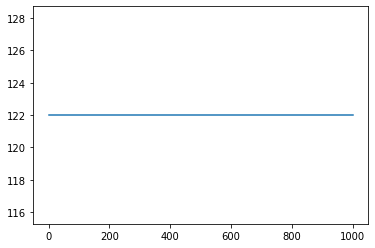

Poblacion inicial, best_fitness = 122
Best board found in 0.4851086139678955 seconds (1000 ierations) with 122/162 points:
Last Gen with improvement:  1


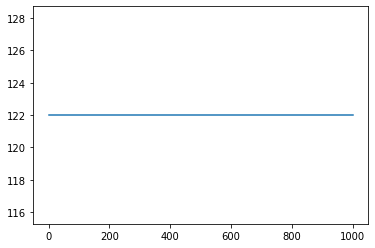

Poblacion inicial, best_fitness = 123
Best board found in 0.4901103973388672 seconds (1000 ierations) with 123/162 points:
Last Gen with improvement:  1


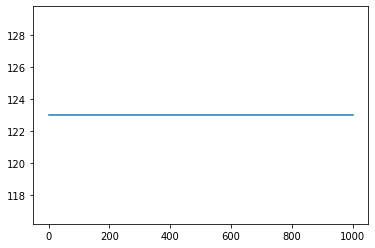

Poblacion inicial, best_fitness = 121
Best board found in 0.48911046981811523 seconds (1000 ierations) with 121/162 points:
Last Gen with improvement:  1


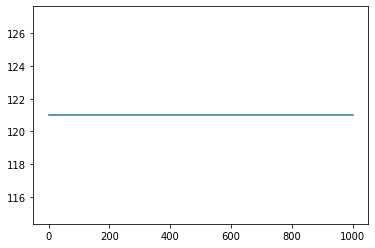

Poblacion inicial, best_fitness = 125
Best board found in 0.4936184883117676 seconds (1000 ierations) with 125/162 points:
Last Gen with improvement:  1


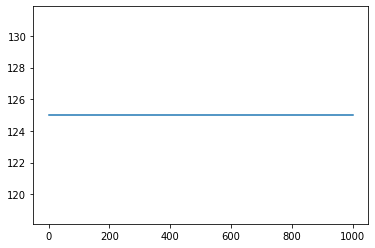

Poblacion inicial, best_fitness = 121
Best board found in 0.4871516227722168 seconds (1000 ierations) with 121/162 points:
Last Gen with improvement:  1


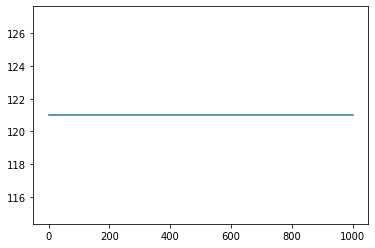

Poblacion inicial, best_fitness = 120
Best board found in 0.4891185760498047 seconds (1000 ierations) with 120/162 points:
Last Gen with improvement:  1


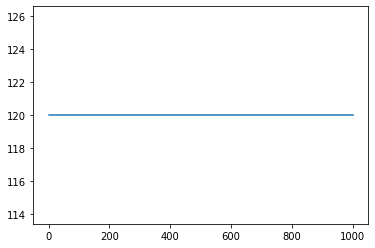

Poblacion inicial, best_fitness = 124
Best board found in 0.4915657043457031 seconds (1000 ierations) with 124/162 points:
Last Gen with improvement:  1


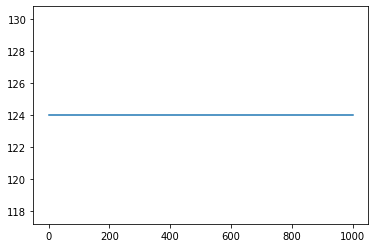

Poblacion inicial, best_fitness = 125
Best board found in 0.49211573600769043 seconds (1000 ierations) with 125/162 points:
Last Gen with improvement:  1


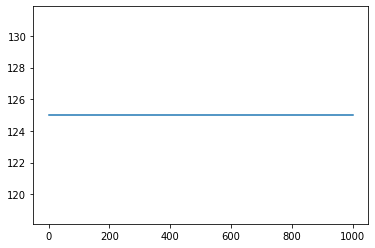

Poblacion inicial, best_fitness = 121
Best board found in 0.48911046981811523 seconds (1000 ierations) with 121/162 points:
Last Gen with improvement:  1


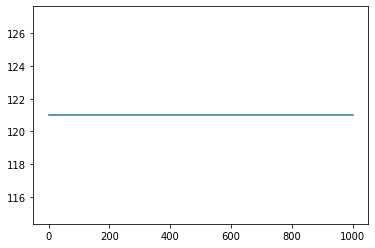

////////////////////////////////////////////////////////////
Taza de Mutacion:  0
Operador de Cruze:  onepoint
Modo de seleccion de padres:  tournament


Poblacion inicial, best_fitness = 119
Best board found in 0.5941338539123535 seconds (1000 ierations) with 119/162 points:
Last Gen with improvement:  1


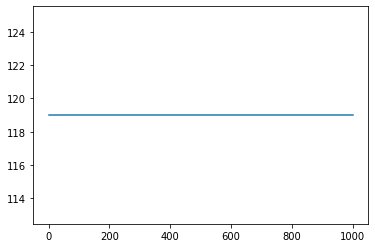

Poblacion inicial, best_fitness = 126
Best board found in 0.584132194519043 seconds (1000 ierations) with 126/162 points:
Last Gen with improvement:  1


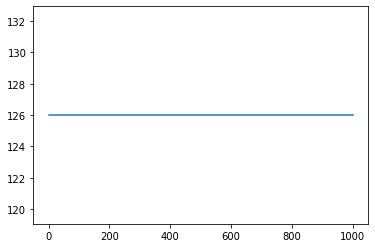

Poblacion inicial, best_fitness = 124
Best board found in 0.5781307220458984 seconds (1000 ierations) with 124/162 points:
Last Gen with improvement:  1


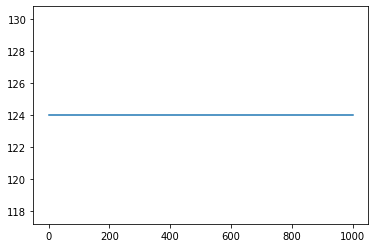

Poblacion inicial, best_fitness = 121
Best board found in 0.5771307945251465 seconds (1000 ierations) with 121/162 points:
Last Gen with improvement:  1


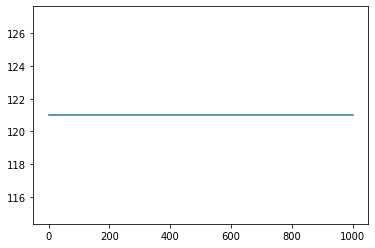

Poblacion inicial, best_fitness = 120
Best board found in 0.5791308879852295 seconds (1000 ierations) with 120/162 points:
Last Gen with improvement:  1


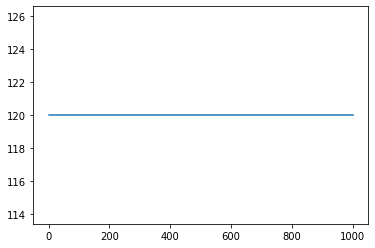

Poblacion inicial, best_fitness = 124
Best board found in 0.5851471424102783 seconds (1000 ierations) with 124/162 points:
Last Gen with improvement:  1


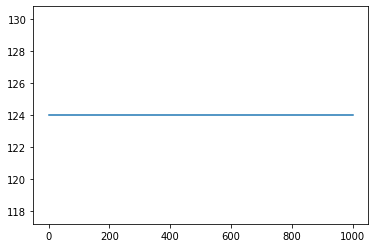

Poblacion inicial, best_fitness = 121
Best board found in 0.5893945693969727 seconds (1000 ierations) with 121/162 points:
Last Gen with improvement:  1


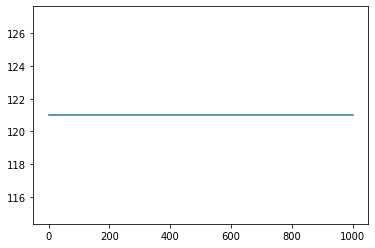

Poblacion inicial, best_fitness = 121
Best board found in 0.5831842422485352 seconds (1000 ierations) with 121/162 points:
Last Gen with improvement:  1


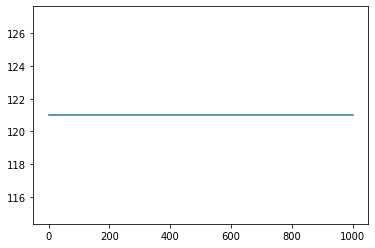

Poblacion inicial, best_fitness = 122
Best board found in 0.5802936553955078 seconds (1000 ierations) with 122/162 points:
Last Gen with improvement:  1


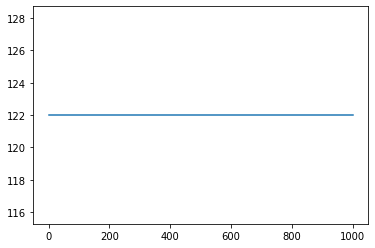

Poblacion inicial, best_fitness = 123
Best board found in 0.5821313858032227 seconds (1000 ierations) with 123/162 points:
Last Gen with improvement:  1


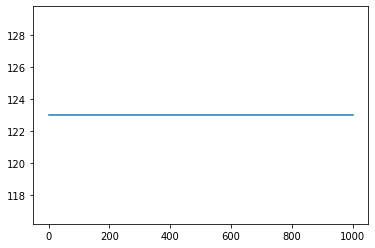

////////////////////////////////////////////////////////////
Taza de Mutacion:  0
Operador de Cruze:  onepoint
Modo de seleccion de padres:  random


Poblacion inicial, best_fitness = 123
Best board found in 0.4831089973449707 seconds (1000 ierations) with 123/162 points:
Last Gen with improvement:  1


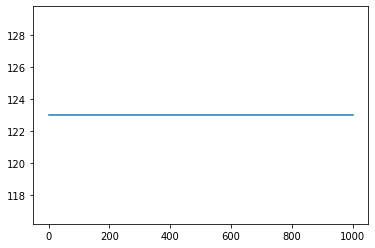

Poblacion inicial, best_fitness = 129
Best board found in 0.48210859298706055 seconds (1000 ierations) with 129/162 points:
Last Gen with improvement:  1


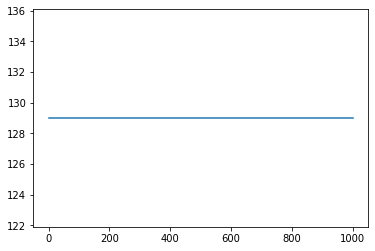

Poblacion inicial, best_fitness = 123
Best board found in 0.48610997200012207 seconds (1000 ierations) with 123/162 points:
Last Gen with improvement:  1


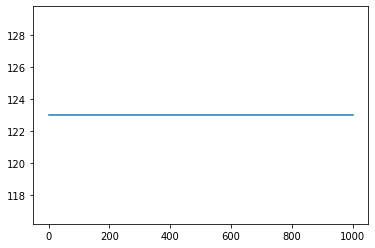

Poblacion inicial, best_fitness = 120
Best board found in 0.4871103763580322 seconds (1000 ierations) with 120/162 points:
Last Gen with improvement:  1


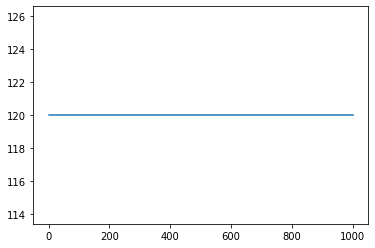

Poblacion inicial, best_fitness = 121
Best board found in 0.49111104011535645 seconds (1000 ierations) with 121/162 points:
Last Gen with improvement:  1


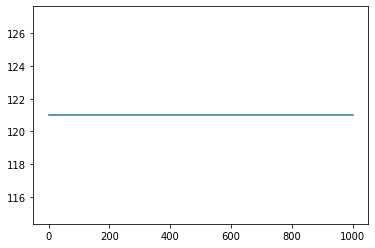

Poblacion inicial, best_fitness = 124
Best board found in 0.4831085205078125 seconds (1000 ierations) with 124/162 points:
Last Gen with improvement:  1


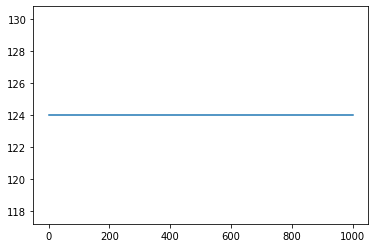

Poblacion inicial, best_fitness = 123
Best board found in 0.4901108741760254 seconds (1000 ierations) with 123/162 points:
Last Gen with improvement:  1


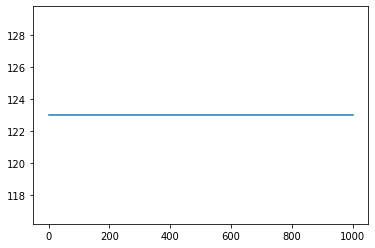

Poblacion inicial, best_fitness = 124
Best board found in 0.4851093292236328 seconds (1000 ierations) with 124/162 points:
Last Gen with improvement:  1


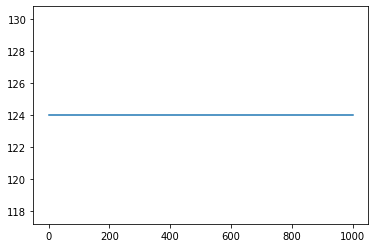

Poblacion inicial, best_fitness = 125
Best board found in 0.48911046981811523 seconds (1000 ierations) with 125/162 points:
Last Gen with improvement:  1


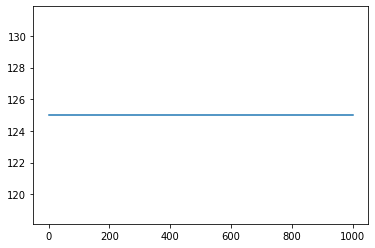

Poblacion inicial, best_fitness = 122
Best board found in 0.4831094741821289 seconds (1000 ierations) with 122/162 points:
Last Gen with improvement:  1


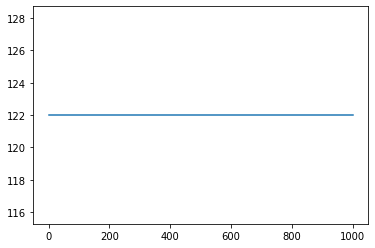

////////////////////////////////////////////////////////////
Taza de Mutacion:  0
Operador de Cruze:  multipoint
Modo de seleccion de padres:  roulette


Poblacion inicial, best_fitness = 123
Best board found in 0.43309712409973145 seconds (1000 ierations) with 123/162 points:
Last Gen with improvement:  1


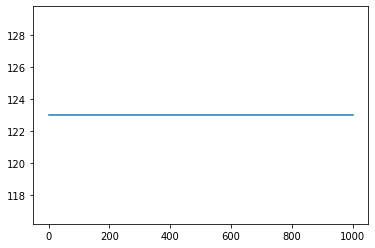

Poblacion inicial, best_fitness = 124
Best board found in 0.43509912490844727 seconds (1000 ierations) with 124/162 points:
Last Gen with improvement:  1


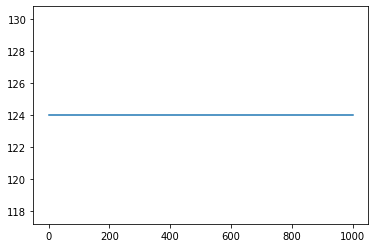

Poblacion inicial, best_fitness = 123
Best board found in 0.42609620094299316 seconds (1000 ierations) with 123/162 points:
Last Gen with improvement:  1


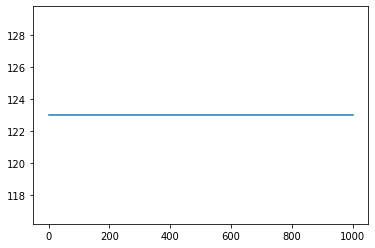

Poblacion inicial, best_fitness = 124
Best board found in 0.425095796585083 seconds (1000 ierations) with 124/162 points:
Last Gen with improvement:  1


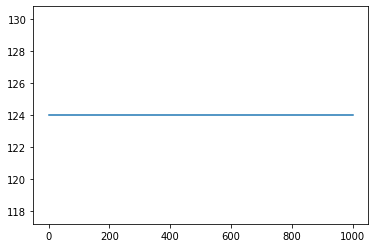

Poblacion inicial, best_fitness = 120
Best board found in 0.42909717559814453 seconds (1000 ierations) with 120/162 points:
Last Gen with improvement:  1


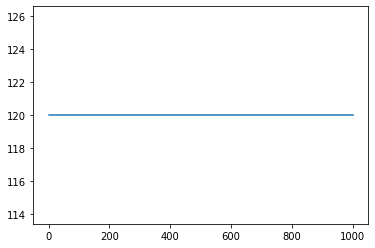

Poblacion inicial, best_fitness = 128
Best board found in 0.4300968647003174 seconds (1000 ierations) with 128/162 points:
Last Gen with improvement:  1


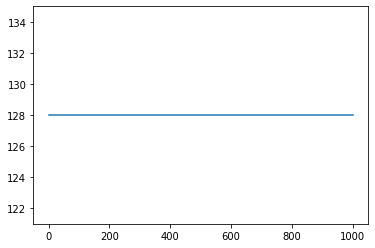

Poblacion inicial, best_fitness = 122
Best board found in 0.43109703063964844 seconds (1000 ierations) with 122/162 points:
Last Gen with improvement:  1


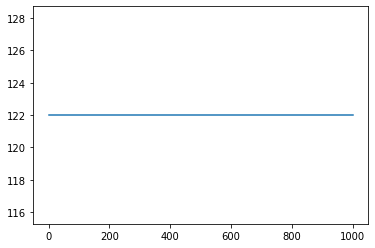

Poblacion inicial, best_fitness = 123
Best board found in 0.4270966053009033 seconds (1000 ierations) with 123/162 points:
Last Gen with improvement:  1


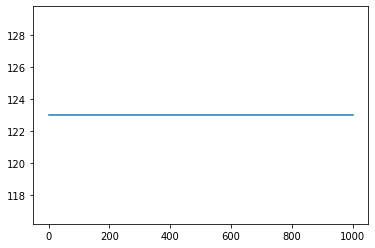

Poblacion inicial, best_fitness = 126
Best board found in 0.4250960350036621 seconds (1000 ierations) with 126/162 points:
Last Gen with improvement:  1


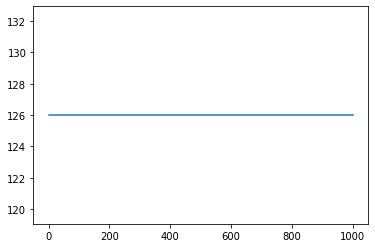

Poblacion inicial, best_fitness = 124
Best board found in 0.4280965328216553 seconds (1000 ierations) with 124/162 points:
Last Gen with improvement:  1


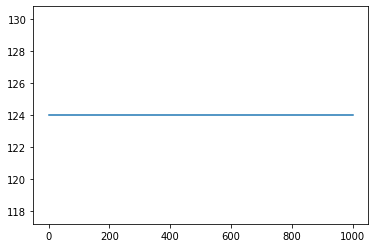

////////////////////////////////////////////////////////////
Taza de Mutacion:  0
Operador de Cruze:  multipoint
Modo de seleccion de padres:  tournament


Poblacion inicial, best_fitness = 122
Best board found in 0.5211176872253418 seconds (1000 ierations) with 122/162 points:
Last Gen with improvement:  1


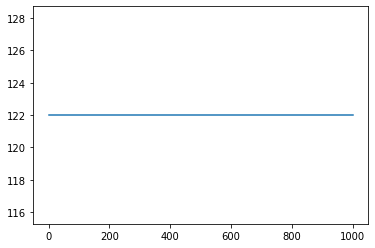

Poblacion inicial, best_fitness = 129
Best board found in 0.5211172103881836 seconds (1000 ierations) with 129/162 points:
Last Gen with improvement:  1


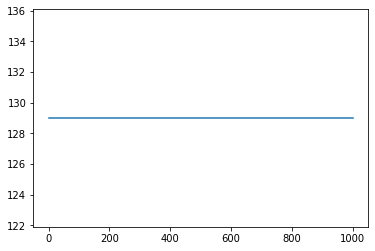

Poblacion inicial, best_fitness = 125
Best board found in 0.5221178531646729 seconds (1000 ierations) with 125/162 points:
Last Gen with improvement:  1


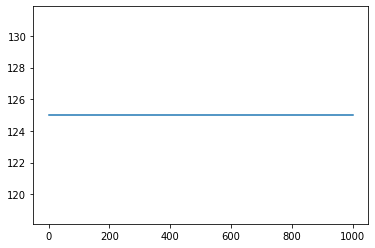

Poblacion inicial, best_fitness = 121
Best board found in 0.5181167125701904 seconds (1000 ierations) with 121/162 points:
Last Gen with improvement:  1


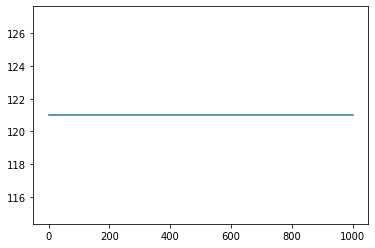

Poblacion inicial, best_fitness = 124
Best board found in 0.513115644454956 seconds (1000 ierations) with 124/162 points:
Last Gen with improvement:  1


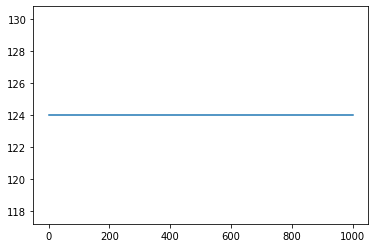

Poblacion inicial, best_fitness = 125
Best board found in 0.5181171894073486 seconds (1000 ierations) with 125/162 points:
Last Gen with improvement:  1


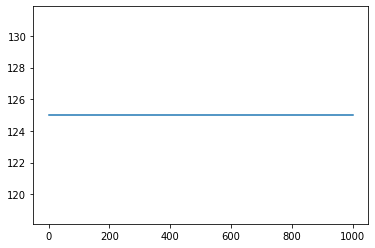

Poblacion inicial, best_fitness = 123
Best board found in 0.5141160488128662 seconds (1000 ierations) with 123/162 points:
Last Gen with improvement:  1


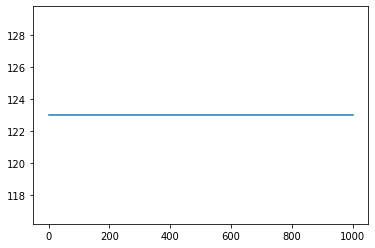

Poblacion inicial, best_fitness = 129
Best board found in 0.522118330001831 seconds (1000 ierations) with 129/162 points:
Last Gen with improvement:  1


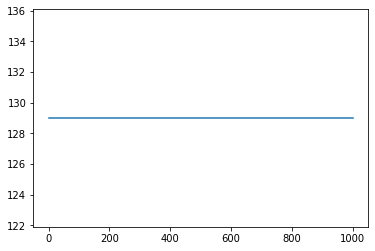

Poblacion inicial, best_fitness = 123
Best board found in 0.5211174488067627 seconds (1000 ierations) with 123/162 points:
Last Gen with improvement:  1


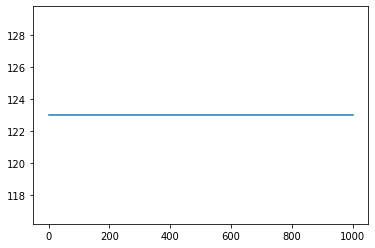

Poblacion inicial, best_fitness = 126
Best board found in 0.523118257522583 seconds (1000 ierations) with 126/162 points:
Last Gen with improvement:  1


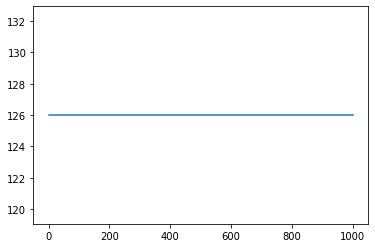

////////////////////////////////////////////////////////////
Taza de Mutacion:  0
Operador de Cruze:  multipoint
Modo de seleccion de padres:  random


Poblacion inicial, best_fitness = 124
Best board found in 0.42409563064575195 seconds (1000 ierations) with 124/162 points:
Last Gen with improvement:  1


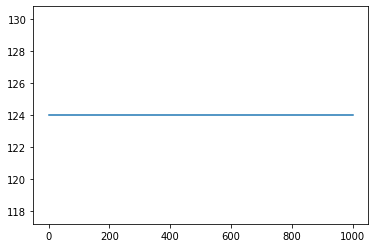

Poblacion inicial, best_fitness = 123
Best board found in 0.4210944175720215 seconds (1000 ierations) with 123/162 points:
Last Gen with improvement:  1


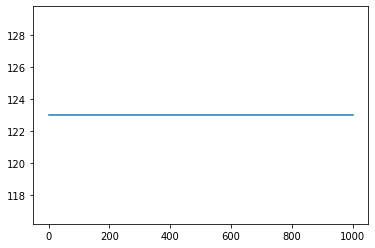

Poblacion inicial, best_fitness = 126
Best board found in 0.423095703125 seconds (1000 ierations) with 126/162 points:
Last Gen with improvement:  1


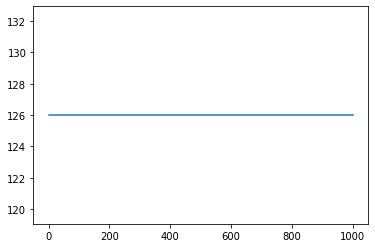

Poblacion inicial, best_fitness = 122
Best board found in 0.4250962734222412 seconds (1000 ierations) with 122/162 points:
Last Gen with improvement:  1


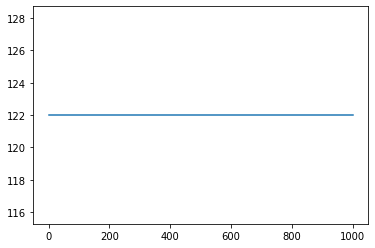

Poblacion inicial, best_fitness = 123
Best board found in 0.42009472846984863 seconds (1000 ierations) with 123/162 points:
Last Gen with improvement:  1


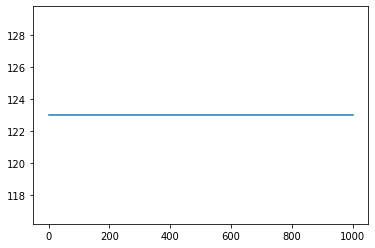

Poblacion inicial, best_fitness = 127
Best board found in 0.4180946350097656 seconds (1000 ierations) with 127/162 points:
Last Gen with improvement:  1


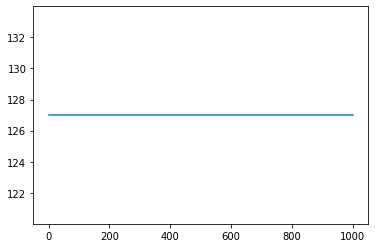

Poblacion inicial, best_fitness = 121
Best board found in 0.41709446907043457 seconds (1000 ierations) with 121/162 points:
Last Gen with improvement:  1


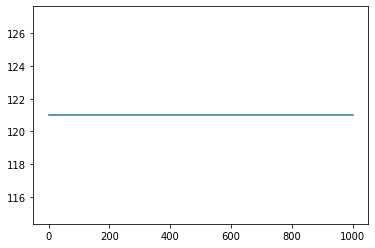

Poblacion inicial, best_fitness = 126
Best board found in 0.4211118221282959 seconds (1000 ierations) with 126/162 points:
Last Gen with improvement:  1


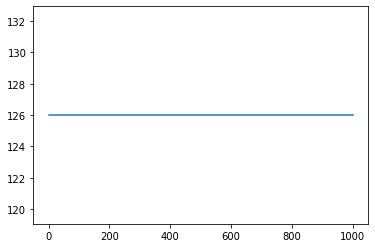

Poblacion inicial, best_fitness = 125
Best board found in 0.41966819763183594 seconds (1000 ierations) with 125/162 points:
Last Gen with improvement:  1


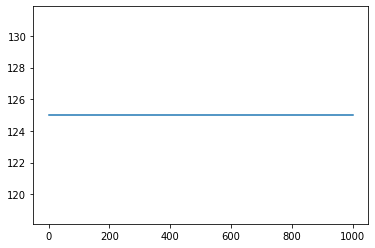

Poblacion inicial, best_fitness = 122
Best board found in 0.4230964183807373 seconds (1000 ierations) with 122/162 points:
Last Gen with improvement:  1


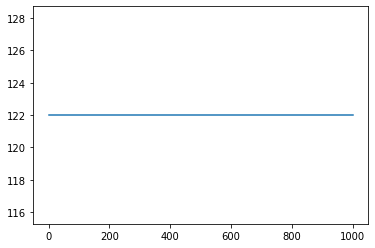

////////////////////////////////////////////////////////////
Taza de Mutacion:  0
Operador de Cruze:  orderpermutation
Modo de seleccion de padres:  roulette


Poblacion inicial, best_fitness = 122
Best board found in 0.37108349800109863 seconds (1000 ierations) with 122/162 points:
Last Gen with improvement:  1


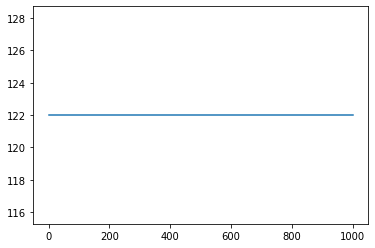

Poblacion inicial, best_fitness = 127
Best board found in 0.3720839023590088 seconds (1000 ierations) with 127/162 points:
Last Gen with improvement:  1


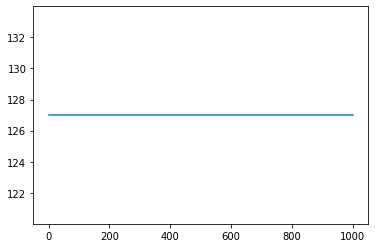

Poblacion inicial, best_fitness = 127
Best board found in 0.3731095790863037 seconds (1000 ierations) with 127/162 points:
Last Gen with improvement:  1


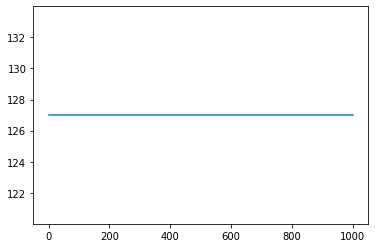

Poblacion inicial, best_fitness = 125
Best board found in 0.3741121292114258 seconds (1000 ierations) with 125/162 points:
Last Gen with improvement:  1


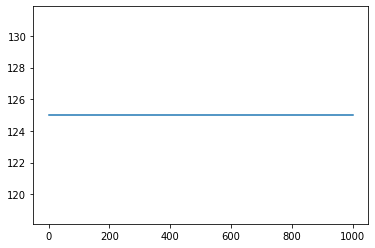

Poblacion inicial, best_fitness = 122
Best board found in 0.37197279930114746 seconds (1000 ierations) with 122/162 points:
Last Gen with improvement:  1


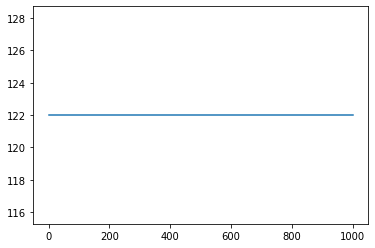

Poblacion inicial, best_fitness = 124
Best board found in 0.37508440017700195 seconds (1000 ierations) with 124/162 points:
Last Gen with improvement:  1


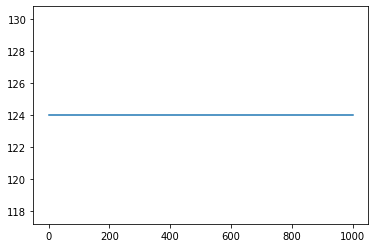

Poblacion inicial, best_fitness = 121
Best board found in 0.37108349800109863 seconds (1000 ierations) with 121/162 points:
Last Gen with improvement:  1


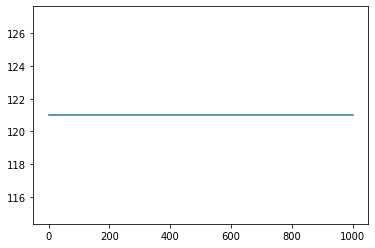

Poblacion inicial, best_fitness = 128
Best board found in 0.37508440017700195 seconds (1000 ierations) with 128/162 points:
Last Gen with improvement:  1


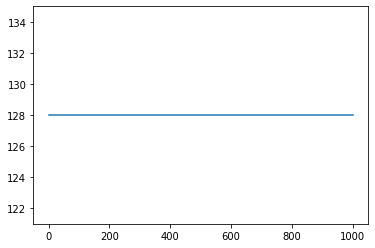

Poblacion inicial, best_fitness = 120
Best board found in 0.3720841407775879 seconds (1000 ierations) with 120/162 points:
Last Gen with improvement:  1


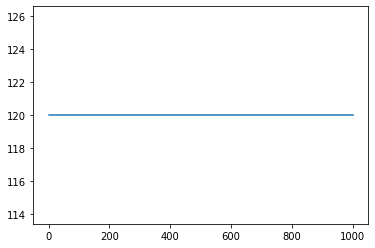

Poblacion inicial, best_fitness = 120
Best board found in 0.37108349800109863 seconds (1000 ierations) with 120/162 points:
Last Gen with improvement:  1


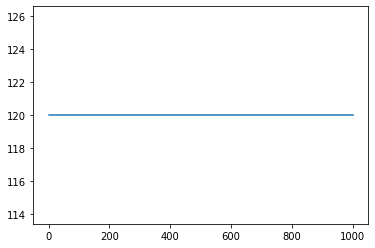

////////////////////////////////////////////////////////////
Taza de Mutacion:  0
Operador de Cruze:  orderpermutation
Modo de seleccion de padres:  tournament


Poblacion inicial, best_fitness = 124
Best board found in 0.46610450744628906 seconds (1000 ierations) with 124/162 points:
Last Gen with improvement:  1


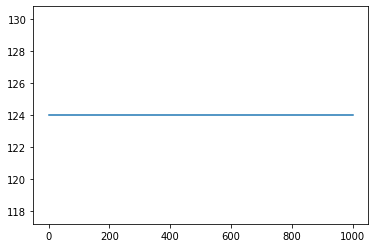

Poblacion inicial, best_fitness = 124
Best board found in 0.46410417556762695 seconds (1000 ierations) with 124/162 points:
Last Gen with improvement:  1


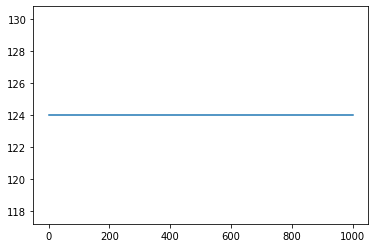

Poblacion inicial, best_fitness = 122
Best board found in 0.46312713623046875 seconds (1000 ierations) with 122/162 points:
Last Gen with improvement:  1


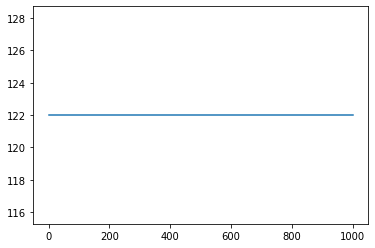

Poblacion inicial, best_fitness = 121
Best board found in 0.4651341438293457 seconds (1000 ierations) with 121/162 points:
Last Gen with improvement:  1


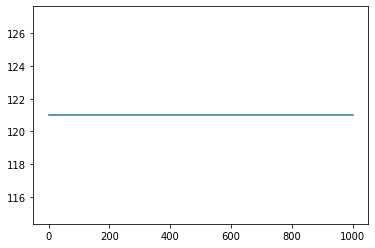

Poblacion inicial, best_fitness = 118
Best board found in 0.46393728256225586 seconds (1000 ierations) with 118/162 points:
Last Gen with improvement:  1


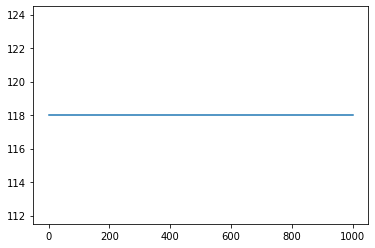

Poblacion inicial, best_fitness = 125
Best board found in 0.4671058654785156 seconds (1000 ierations) with 125/162 points:
Last Gen with improvement:  1


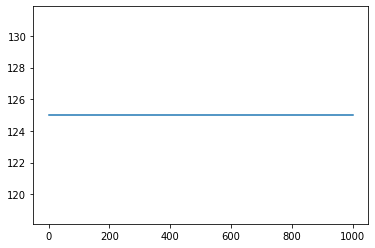

Poblacion inicial, best_fitness = 119
Best board found in 0.46710705757141113 seconds (1000 ierations) with 119/162 points:
Last Gen with improvement:  1


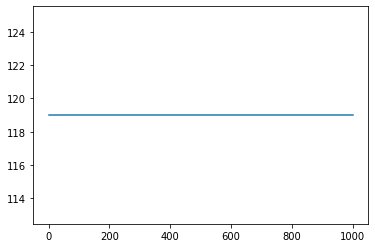

Poblacion inicial, best_fitness = 120
Best board found in 0.4611039161682129 seconds (1000 ierations) with 120/162 points:
Last Gen with improvement:  1


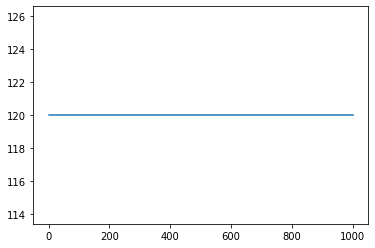

Poblacion inicial, best_fitness = 124
Best board found in 0.4651052951812744 seconds (1000 ierations) with 124/162 points:
Last Gen with improvement:  1


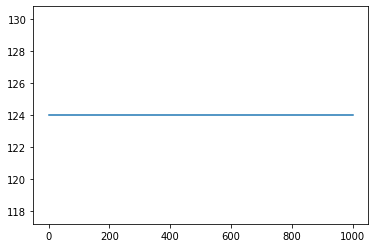

Poblacion inicial, best_fitness = 121
Best board found in 0.46610569953918457 seconds (1000 ierations) with 121/162 points:
Last Gen with improvement:  1


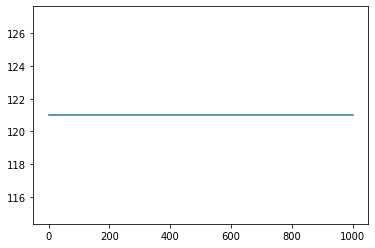

////////////////////////////////////////////////////////////
Taza de Mutacion:  0
Operador de Cruze:  orderpermutation
Modo de seleccion de padres:  random


Poblacion inicial, best_fitness = 123
Best board found in 0.3650827407836914 seconds (1000 ierations) with 123/162 points:
Last Gen with improvement:  1


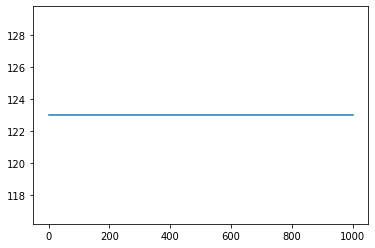

Poblacion inicial, best_fitness = 124
Best board found in 0.3670823574066162 seconds (1000 ierations) with 124/162 points:
Last Gen with improvement:  1


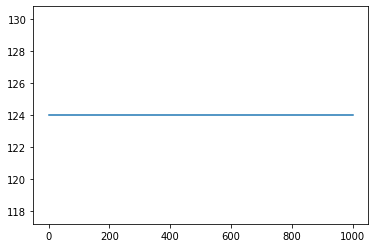

Poblacion inicial, best_fitness = 123
Best board found in 0.36608266830444336 seconds (1000 ierations) with 123/162 points:
Last Gen with improvement:  1


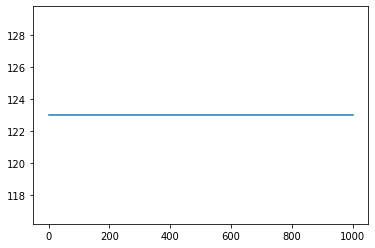

Poblacion inicial, best_fitness = 122
Best board found in 0.3690831661224365 seconds (1000 ierations) with 122/162 points:
Last Gen with improvement:  1


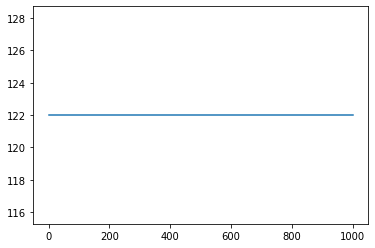

Poblacion inicial, best_fitness = 126
Best board found in 0.36608290672302246 seconds (1000 ierations) with 126/162 points:
Last Gen with improvement:  1


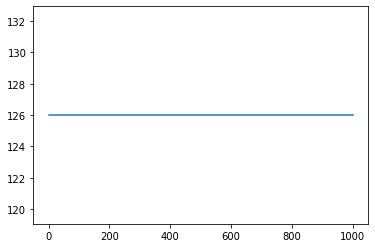

Poblacion inicial, best_fitness = 123
Best board found in 0.3630819320678711 seconds (1000 ierations) with 123/162 points:
Last Gen with improvement:  1


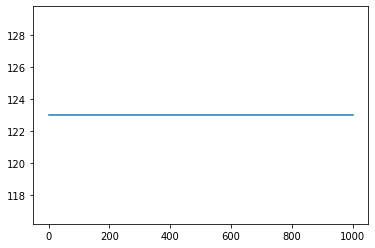

Poblacion inicial, best_fitness = 126
Best board found in 0.36608314514160156 seconds (1000 ierations) with 126/162 points:
Last Gen with improvement:  1


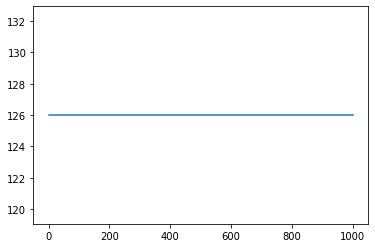

Poblacion inicial, best_fitness = 122
Best board found in 0.3690834045410156 seconds (1000 ierations) with 122/162 points:
Last Gen with improvement:  1


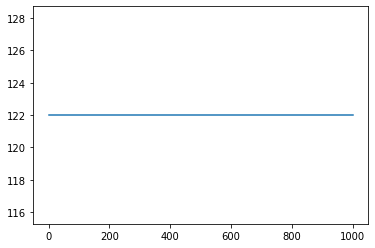

Poblacion inicial, best_fitness = 121
Best board found in 0.3630819320678711 seconds (1000 ierations) with 121/162 points:
Last Gen with improvement:  1


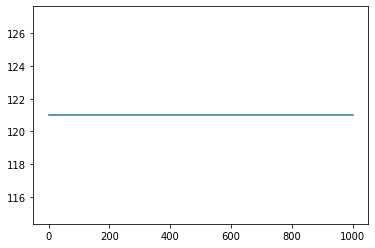

Poblacion inicial, best_fitness = 127
Best board found in 0.3670828342437744 seconds (1000 ierations) with 127/162 points:
Last Gen with improvement:  1


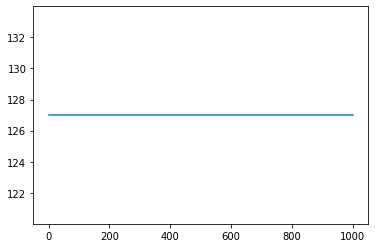

////////////////////////////////////////////////////////////
Taza de Mutacion:  0
Operador de Cruze:  PMXpermutation
Modo de seleccion de padres:  roulette


Poblacion inicial, best_fitness = 122
Best board found in 5.545252561569214 seconds (1000 ierations) with 122/162 points:
Last Gen with improvement:  1


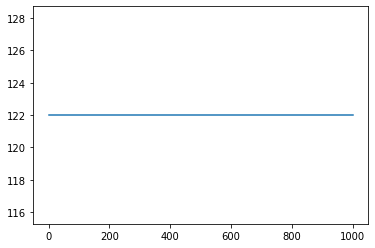

Poblacion inicial, best_fitness = 122
Best board found in 5.547253608703613 seconds (1000 ierations) with 122/162 points:
Last Gen with improvement:  1


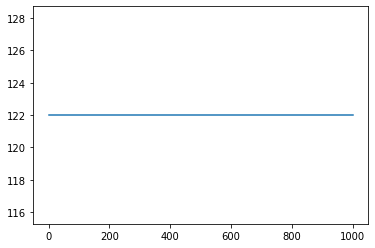

Poblacion inicial, best_fitness = 124
Best board found in 5.538043260574341 seconds (1000 ierations) with 124/162 points:
Last Gen with improvement:  1


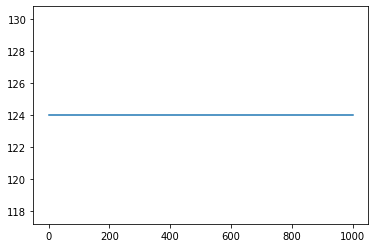

Poblacion inicial, best_fitness = 129
Best board found in 5.559224367141724 seconds (1000 ierations) with 129/162 points:
Last Gen with improvement:  1


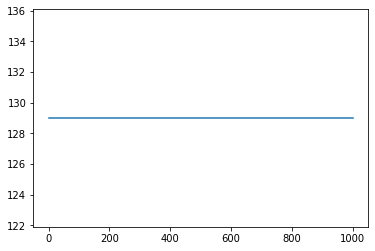

Poblacion inicial, best_fitness = 122
Best board found in 5.3162007331848145 seconds (1000 ierations) with 122/162 points:
Last Gen with improvement:  1


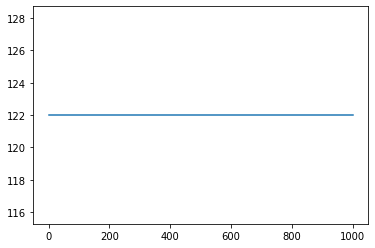

Poblacion inicial, best_fitness = 127
Best board found in 5.575259208679199 seconds (1000 ierations) with 127/162 points:
Last Gen with improvement:  1


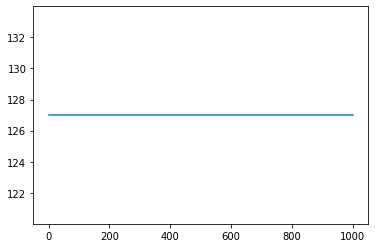

Poblacion inicial, best_fitness = 122
Best board found in 5.277191877365112 seconds (1000 ierations) with 122/162 points:
Last Gen with improvement:  1


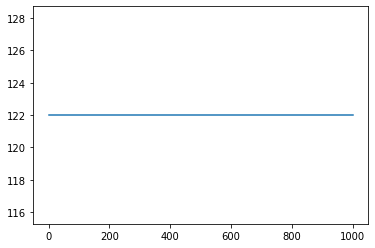

Poblacion inicial, best_fitness = 123
Best board found in 5.57835054397583 seconds (1000 ierations) with 123/162 points:
Last Gen with improvement:  1


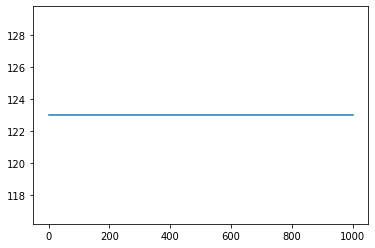

Poblacion inicial, best_fitness = 124
Best board found in 5.524731159210205 seconds (1000 ierations) with 124/162 points:
Last Gen with improvement:  1


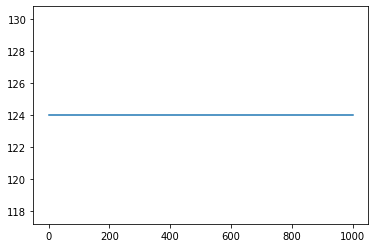

Poblacion inicial, best_fitness = 125
Best board found in 4.816087245941162 seconds (1000 ierations) with 125/162 points:
Last Gen with improvement:  1


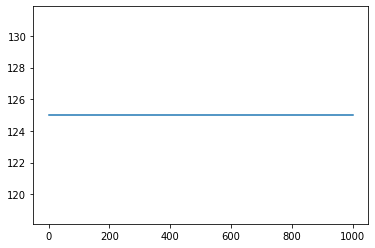

////////////////////////////////////////////////////////////
Taza de Mutacion:  0
Operador de Cruze:  PMXpermutation
Modo de seleccion de padres:  tournament


Poblacion inicial, best_fitness = 125
Best board found in 4.460007190704346 seconds (1000 ierations) with 125/162 points:
Last Gen with improvement:  1


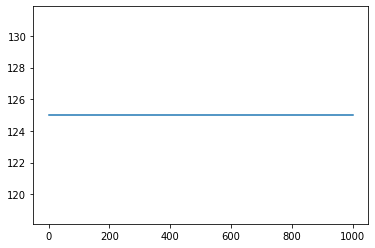

Poblacion inicial, best_fitness = 123
Best board found in 4.470008611679077 seconds (1000 ierations) with 123/162 points:
Last Gen with improvement:  1


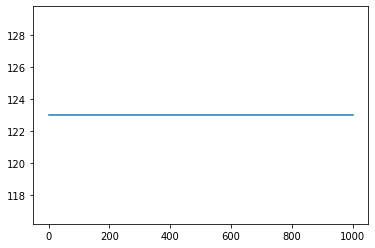

Poblacion inicial, best_fitness = 124
Best board found in 4.490014314651489 seconds (1000 ierations) with 124/162 points:
Last Gen with improvement:  1


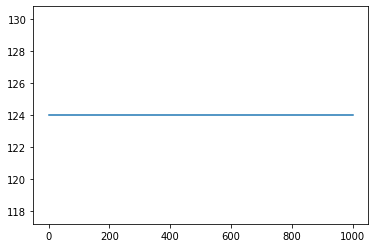

Poblacion inicial, best_fitness = 120
Best board found in 4.5282793045043945 seconds (1000 ierations) with 120/162 points:
Last Gen with improvement:  1


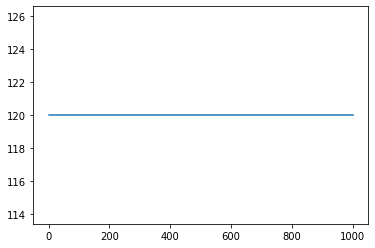

Poblacion inicial, best_fitness = 125
Best board found in 4.525697946548462 seconds (1000 ierations) with 125/162 points:
Last Gen with improvement:  1


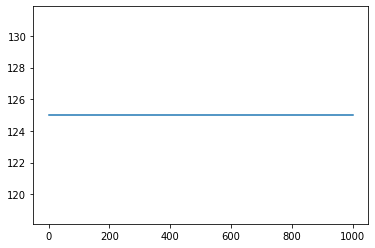

Poblacion inicial, best_fitness = 119
Best board found in 4.480757236480713 seconds (1000 ierations) with 119/162 points:
Last Gen with improvement:  1


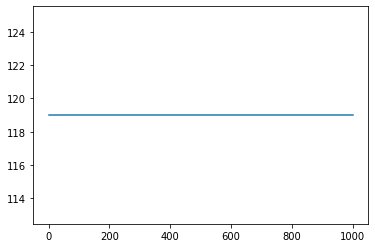

Poblacion inicial, best_fitness = 124
Best board found in 4.506017684936523 seconds (1000 ierations) with 124/162 points:
Last Gen with improvement:  1


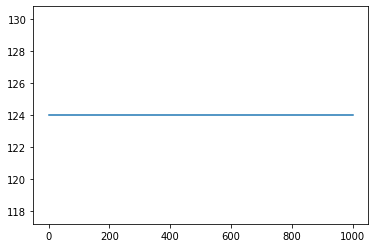

Poblacion inicial, best_fitness = 123
Best board found in 4.489013195037842 seconds (1000 ierations) with 123/162 points:
Last Gen with improvement:  1


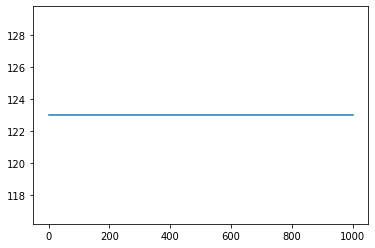

Poblacion inicial, best_fitness = 120
Best board found in 4.5310235023498535 seconds (1000 ierations) with 120/162 points:
Last Gen with improvement:  1


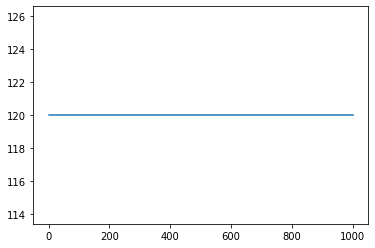

Poblacion inicial, best_fitness = 124
Best board found in 4.482193946838379 seconds (1000 ierations) with 124/162 points:
Last Gen with improvement:  1


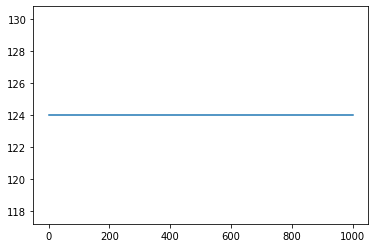

////////////////////////////////////////////////////////////
Taza de Mutacion:  0
Operador de Cruze:  PMXpermutation
Modo de seleccion de padres:  random


Poblacion inicial, best_fitness = 118
Best board found in 5.17084813117981 seconds (1000 ierations) with 118/162 points:
Last Gen with improvement:  1


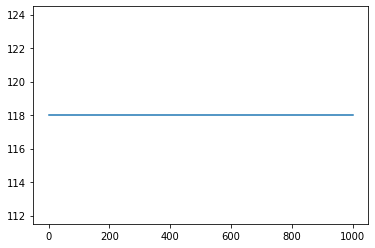

Poblacion inicial, best_fitness = 124
Best board found in 5.037137269973755 seconds (1000 ierations) with 124/162 points:
Last Gen with improvement:  1


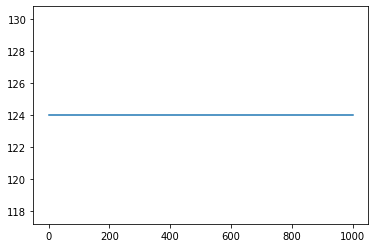

Poblacion inicial, best_fitness = 124
Best board found in 5.036137104034424 seconds (1000 ierations) with 124/162 points:
Last Gen with improvement:  1


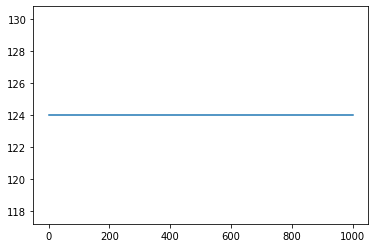

Poblacion inicial, best_fitness = 119
Best board found in 4.974123477935791 seconds (1000 ierations) with 119/162 points:
Last Gen with improvement:  1


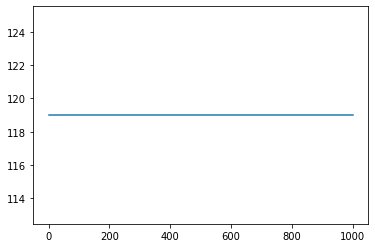

Poblacion inicial, best_fitness = 124
Best board found in 4.638555526733398 seconds (1000 ierations) with 124/162 points:
Last Gen with improvement:  1


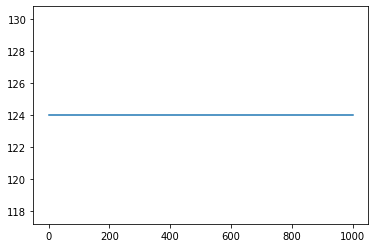

Poblacion inicial, best_fitness = 125
Best board found in 4.6834821701049805 seconds (1000 ierations) with 125/162 points:
Last Gen with improvement:  1


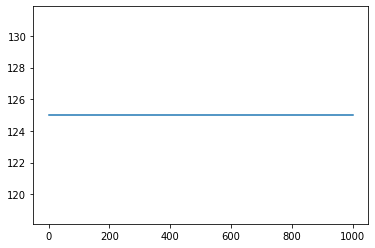

Poblacion inicial, best_fitness = 121
Best board found in 5.073155403137207 seconds (1000 ierations) with 121/162 points:
Last Gen with improvement:  1


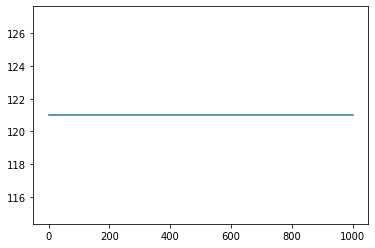

Poblacion inicial, best_fitness = 124
Best board found in 4.870100021362305 seconds (1000 ierations) with 124/162 points:
Last Gen with improvement:  1


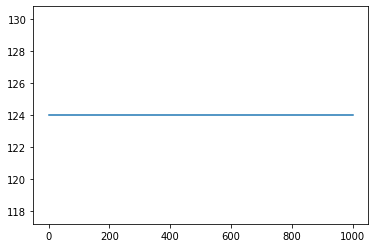

Poblacion inicial, best_fitness = 122
Best board found in 4.531023263931274 seconds (1000 ierations) with 122/162 points:
Last Gen with improvement:  1


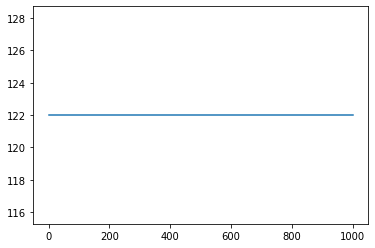

Poblacion inicial, best_fitness = 125
Best board found in 4.703085660934448 seconds (1000 ierations) with 125/162 points:
Last Gen with improvement:  1


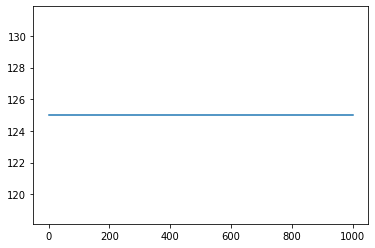

In [14]:
#generacion_fitness_mean_list=[]
#generacion_fitness_max_list=[]
#bestfitness_02a_max_mean_list=[]


pmut_index = pmut[0]

gen_max_fitness_mean_list = []
max_fitness_mean_list = []

for crossover_index in crossover:
    for metodoSeleccionpadres_index in metodoSeleccionpadres:

        print("/"*60)
        print("Taza de Mutacion: ", pmut_index)
        print("Operador de Cruze: ", crossover_index)
        print('Modo de seleccion de padres: ', metodoSeleccionpadres_index)
        print('\n')
        
        gen_max_fitness_list = []
        max_fitness_list = []

        for i in range(0,10):
            population = init_population(num_individuals, board, initialEntries)
            best_ind, bestfitness, gen_max_fitness, max_fitness = genetic_algorithm(population, fitness_fn, ngen = ngen,
                                                      pmut = pmut_index,
                                                      pcx = pcx,
                                                      tournament_size = tournament_size, 
                                                      crossover = crossover_index,
                                                      mutation = mutation[0],
                                                      selection_parents_method = metodoSeleccionpadres_index,
                                                      selection_survivors_method = metodoSeleccionsobrevivientes[0])
            plt.plot(bestfitness)
            plt.show()

            gen_max_fitness_list.append(gen_max_fitness)
            max_fitness_list.append(max_fitness)



        gen_max_fitness_array=np.asarray(gen_max_fitness_list)
        max_fitness_array=np.asarray(max_fitness_list)
        gen_max_fitness_mean=np.mean(gen_max_fitness_array)
        max_fitness_mean=np.mean(max_fitness_array)

        gen_max_fitness_mean_list.append(gen_max_fitness_mean)
        max_fitness_mean_list.append(max_fitness_mean)



                

<function matplotlib.pyplot.show(close=None, block=None)>

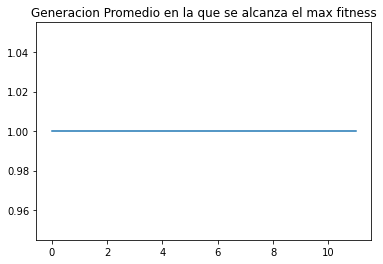

In [15]:
plt.plot(gen_max_fitness_mean_list)
plt.title('Generacion Promedio en la que se alcanza el max fitness')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

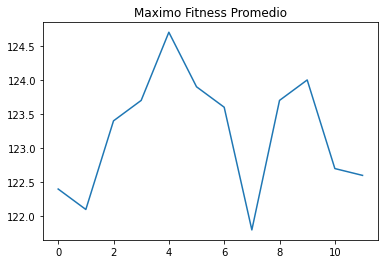

In [16]:
plt.plot(max_fitness_mean_list)
plt.title('Maximo Fitness Promedio')
plt.show

////////////////////////////////////////////////////////////
Taza de Mutacion:  0.2
Operador de Cruze:  onepoint
Modo de seleccion de padres:  tournament


Poblacion inicial, best_fitness = 122
Best board found in 0.9722201824188232 seconds (1000 ierations) with 144/162 points:
Last Gen with improvement:  730


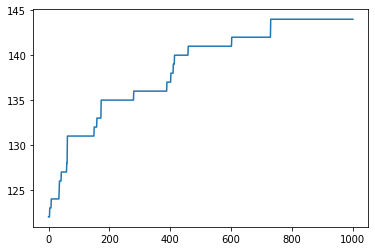

Poblacion inicial, best_fitness = 122
Best board found in 0.9572160243988037 seconds (1000 ierations) with 143/162 points:
Last Gen with improvement:  999


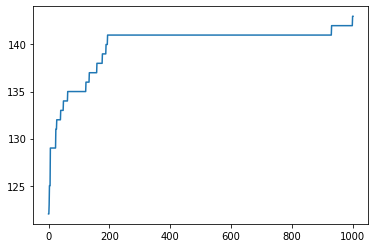

Poblacion inicial, best_fitness = 120
Best board found in 0.9457571506500244 seconds (1000 ierations) with 141/162 points:
Last Gen with improvement:  756


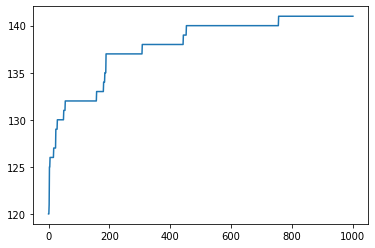

Poblacion inicial, best_fitness = 121
Best board found in 0.9572162628173828 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  385


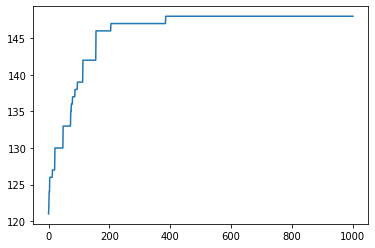

Poblacion inicial, best_fitness = 122
Best board found in 0.9407427310943604 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  671


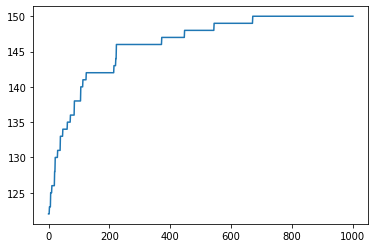

Poblacion inicial, best_fitness = 123
Best board found in 0.9762206077575684 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  711


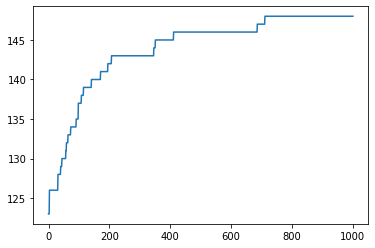

Poblacion inicial, best_fitness = 122
Best board found in 0.9632172584533691 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  780


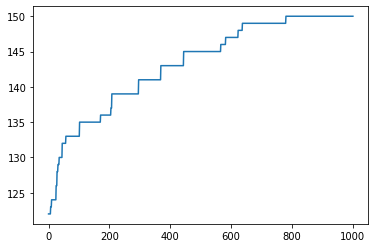

Poblacion inicial, best_fitness = 120
Best board found in 0.9532153606414795 seconds (1000 ierations) with 146/162 points:
Last Gen with improvement:  360


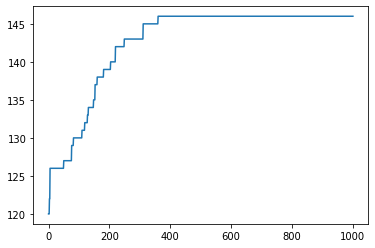

Poblacion inicial, best_fitness = 121
Best board found in 0.9648606777191162 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  546


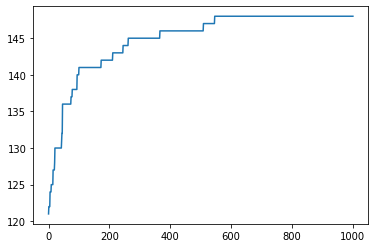

Poblacion inicial, best_fitness = 124
Best board found in 0.946821928024292 seconds (1000 ierations) with 145/162 points:
Last Gen with improvement:  186


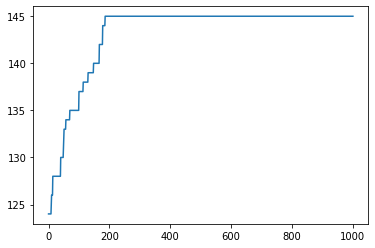

////////////////////////////////////////////////////////////
Taza de Mutacion:  0.2
Operador de Cruze:  multipoint
Modo de seleccion de padres:  tournament


Poblacion inicial, best_fitness = 121
Best board found in 0.896003007888794 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  260


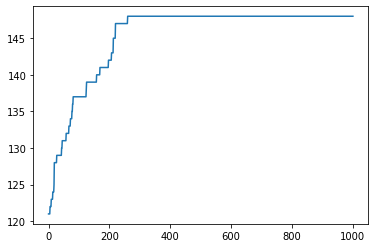

Poblacion inicial, best_fitness = 125
Best board found in 0.8999989032745361 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  235


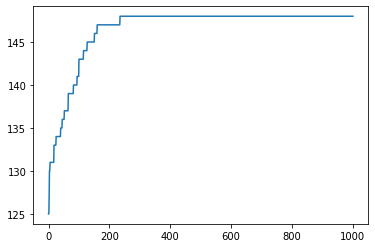

Poblacion inicial, best_fitness = 121
Best board found in 0.8850092887878418 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  220


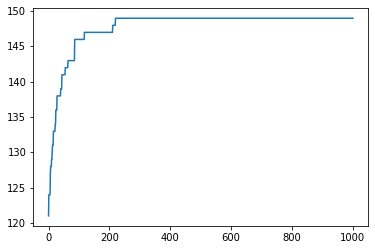

Poblacion inicial, best_fitness = 122
Best board found in 0.8800139427185059 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  693


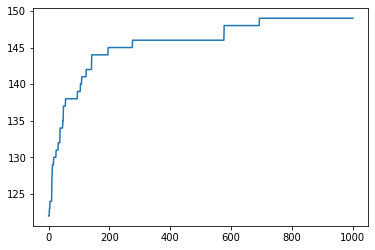

Poblacion inicial, best_fitness = 127
Best board found in 0.8853175640106201 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  821


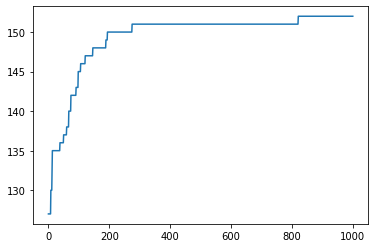

Poblacion inicial, best_fitness = 123
Best board found in 0.9010019302368164 seconds (1000 ierations) with 147/162 points:
Last Gen with improvement:  372


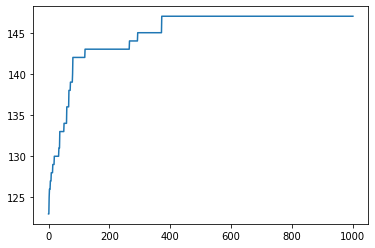

Poblacion inicial, best_fitness = 122
Best board found in 0.8891201019287109 seconds (1000 ierations) with 146/162 points:
Last Gen with improvement:  505


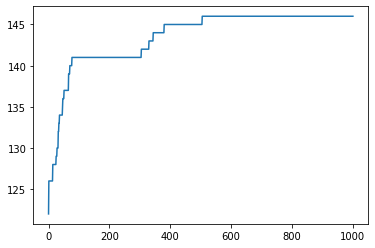

Poblacion inicial, best_fitness = 124
Best board found in 0.8720028400421143 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  605


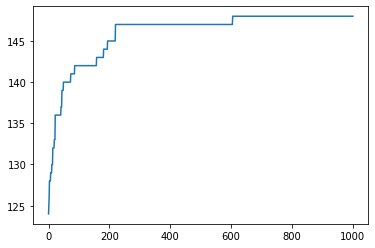

Poblacion inicial, best_fitness = 122
Best board found in 0.8870041370391846 seconds (1000 ierations) with 154/162 points:
Last Gen with improvement:  371


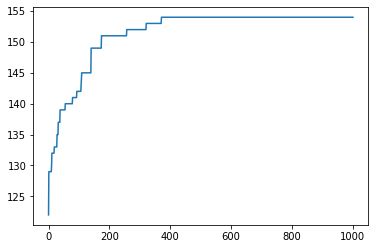

Poblacion inicial, best_fitness = 128
Best board found in 0.8930063247680664 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  404


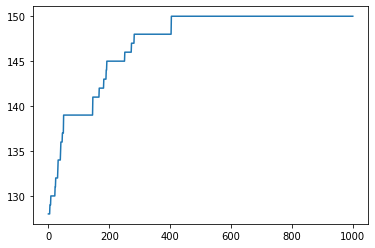

////////////////////////////////////////////////////////////
Taza de Mutacion:  0.2
Operador de Cruze:  orderpermutation
Modo de seleccion de padres:  tournament


Poblacion inicial, best_fitness = 123
Best board found in 0.8320043087005615 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  381


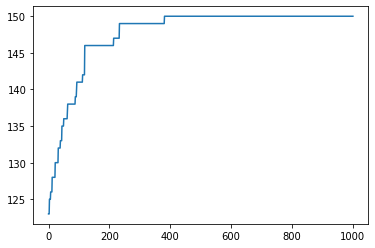

Poblacion inicial, best_fitness = 122
Best board found in 0.8330063819885254 seconds (1000 ierations) with 154/162 points:
Last Gen with improvement:  972


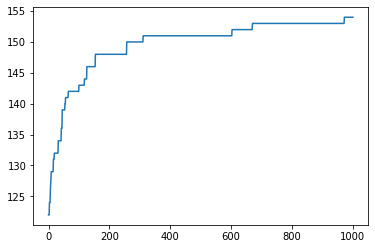

Poblacion inicial, best_fitness = 120
Best board found in 0.8209967613220215 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  503


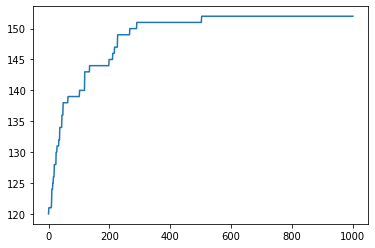

Poblacion inicial, best_fitness = 124
Best board found in 0.8411960601806641 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  373


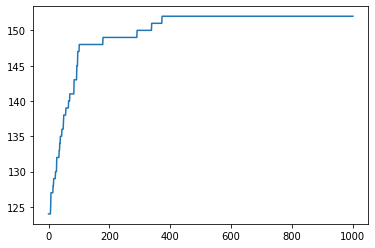

Poblacion inicial, best_fitness = 124
Best board found in 0.8344321250915527 seconds (1000 ierations) with 151/162 points:
Last Gen with improvement:  569


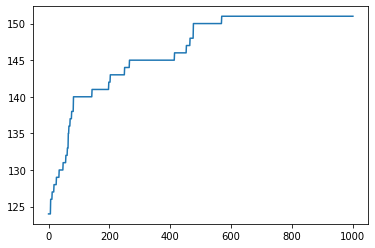

Poblacion inicial, best_fitness = 126
Best board found in 0.8301873207092285 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  129


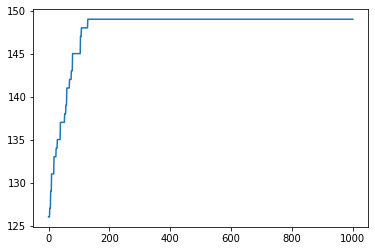

Poblacion inicial, best_fitness = 126
Best board found in 0.8321878910064697 seconds (1000 ierations) with 153/162 points:
Last Gen with improvement:  286


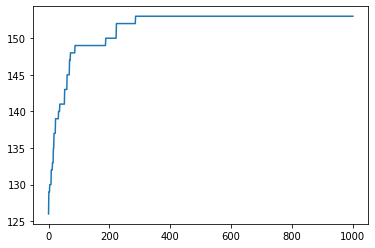

Poblacion inicial, best_fitness = 123
Best board found in 0.8271868228912354 seconds (1000 ierations) with 155/162 points:
Last Gen with improvement:  338


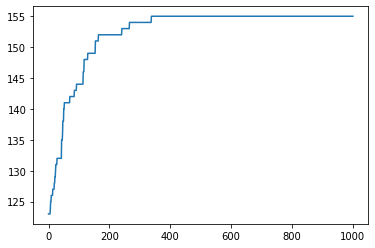

Poblacion inicial, best_fitness = 122
Best board found in 0.8401896953582764 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  263


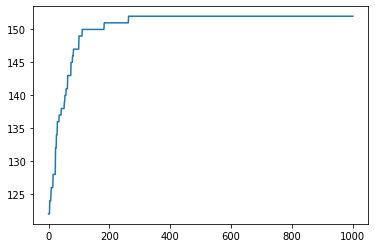

Poblacion inicial, best_fitness = 122
Best board found in 0.8201854228973389 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  679


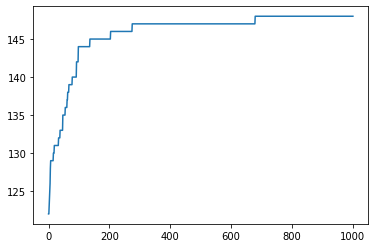

////////////////////////////////////////////////////////////
Taza de Mutacion:  0.2
Operador de Cruze:  PMXpermutation
Modo de seleccion de padres:  tournament


Poblacion inicial, best_fitness = 123
Best board found in 4.837092638015747 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  253


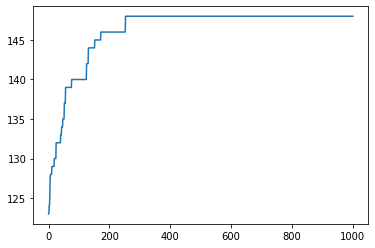

Poblacion inicial, best_fitness = 124
Best board found in 4.797083139419556 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  485


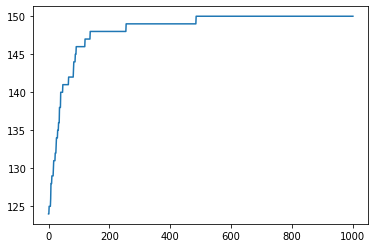

Poblacion inicial, best_fitness = 129
Best board found in 4.819273948669434 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  368


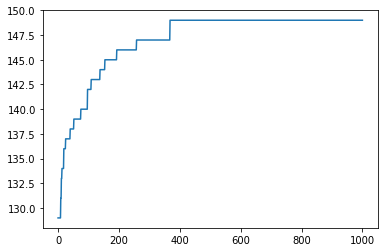

Poblacion inicial, best_fitness = 123
Best board found in 4.795328617095947 seconds (1000 ierations) with 147/162 points:
Last Gen with improvement:  271


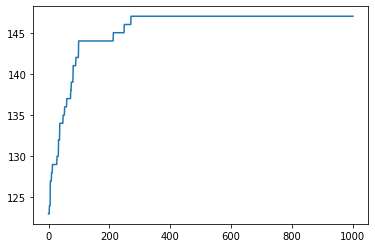

Poblacion inicial, best_fitness = 129
Best board found in 4.8050537109375 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  175


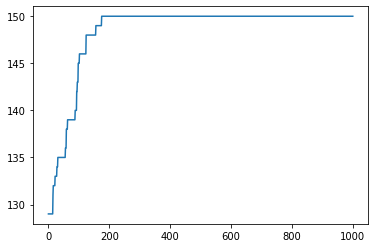

Poblacion inicial, best_fitness = 122
Best board found in 4.80700421333313 seconds (1000 ierations) with 146/162 points:
Last Gen with improvement:  183


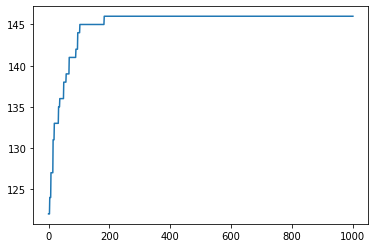

Poblacion inicial, best_fitness = 122
Best board found in 4.796440839767456 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  145


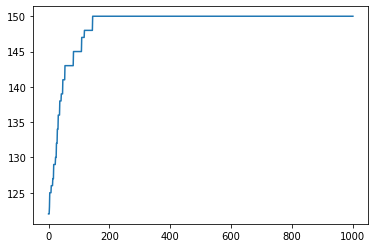

Poblacion inicial, best_fitness = 124
Best board found in 4.802083969116211 seconds (1000 ierations) with 145/162 points:
Last Gen with improvement:  207


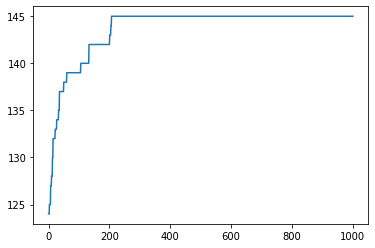

Poblacion inicial, best_fitness = 125
Best board found in 4.79108190536499 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  616


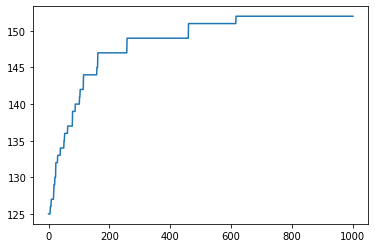

Poblacion inicial, best_fitness = 122
Best board found in 4.795081853866577 seconds (1000 ierations) with 151/162 points:
Last Gen with improvement:  592


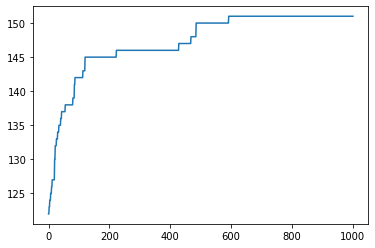

In [17]:
#generacion_fitness_mean_list=[]
#generacion_fitness_max_list=[]
#bestfitness_02a_max_mean_list=[]


pmut_index = pmut[1]
metodoSeleccionpadres_index = metodoSeleccionpadres[1]

gen_max_fitness_mean_list = []
max_fitness_mean_list = []


for crossover_index in crossover:

    print("/"*60)
    print("Taza de Mutacion: ", pmut_index)
    print("Operador de Cruze: ", crossover_index)
    print('Modo de seleccion de padres: ', metodoSeleccionpadres_index)
    print('\n')

    gen_max_fitness_list = []
    max_fitness_list = []

    for i in range(0,10):
        population = init_population(num_individuals, board, initialEntries)
        best_ind, bestfitness, gen_max_fitness, max_fitness = genetic_algorithm(population, fitness_fn, ngen = ngen,
                                                  pmut = pmut_index,
                                                  pcx = pcx,
                                                  tournament_size = tournament_size, 
                                                  crossover = crossover_index,
                                                  mutation = mutation[0],
                                                  selection_parents_method = metodoSeleccionpadres_index,
                                                  selection_survivors_method = metodoSeleccionsobrevivientes[0])
        plt.plot(bestfitness)
        plt.show()

        gen_max_fitness_list.append(gen_max_fitness)
        max_fitness_list.append(max_fitness)



    gen_max_fitness_array=np.asarray(gen_max_fitness_list)
    max_fitness_array=np.asarray(max_fitness_list)
    gen_max_fitness_mean=np.mean(gen_max_fitness_array)
    max_fitness_mean=np.mean(max_fitness_array)

    gen_max_fitness_mean_list.append(gen_max_fitness_mean)
    max_fitness_mean_list.append(max_fitness_mean)



                

<function matplotlib.pyplot.show(close=None, block=None)>

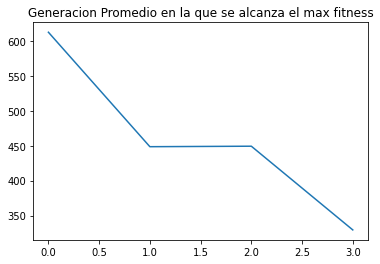

In [18]:
plt.plot(gen_max_fitness_mean_list)
plt.title('Generacion Promedio en la que se alcanza el max fitness')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

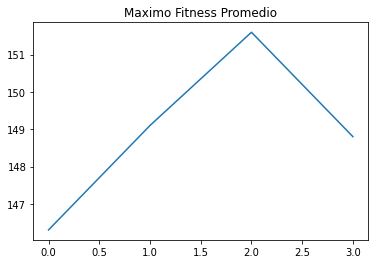

In [19]:
plt.plot(max_fitness_mean_list)
plt.title('Maximo Fitness Promedio')
plt.show

////////////////////////////////////////////////////////////
Taza de Mutacion:  0.3
Operador de Cruze:  onepoint
Modo de seleccion de padres:  tournament


Poblacion inicial, best_fitness = 124
Best board found in 1.1492598056793213 seconds (1000 ierations) with 147/162 points:
Last Gen with improvement:  176


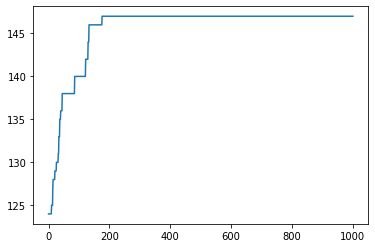

Poblacion inicial, best_fitness = 124
Best board found in 1.1329631805419922 seconds (1000 ierations) with 146/162 points:
Last Gen with improvement:  244


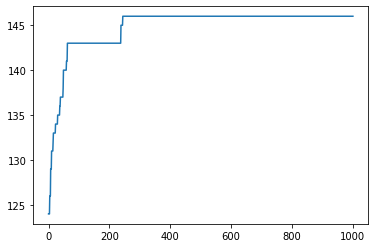

Poblacion inicial, best_fitness = 122
Best board found in 1.099677562713623 seconds (1000 ierations) with 145/162 points:
Last Gen with improvement:  594


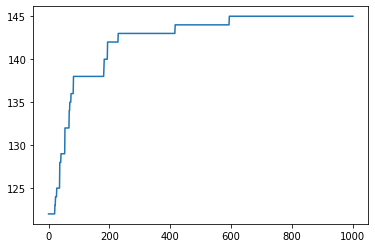

Poblacion inicial, best_fitness = 119
Best board found in 1.137596607208252 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  357


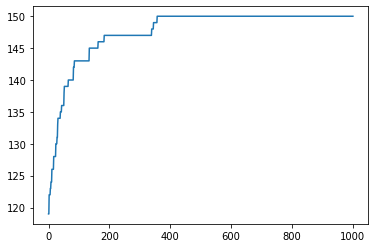

Poblacion inicial, best_fitness = 123
Best board found in 1.1262540817260742 seconds (1000 ierations) with 151/162 points:
Last Gen with improvement:  990


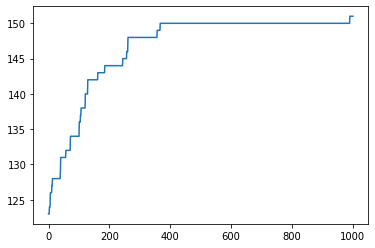

Poblacion inicial, best_fitness = 122
Best board found in 1.1341197490692139 seconds (1000 ierations) with 151/162 points:
Last Gen with improvement:  637


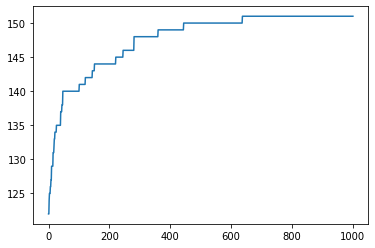

Poblacion inicial, best_fitness = 124
Best board found in 1.1558315753936768 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  952


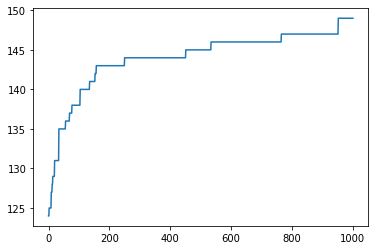

Poblacion inicial, best_fitness = 122
Best board found in 1.1275277137756348 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  350


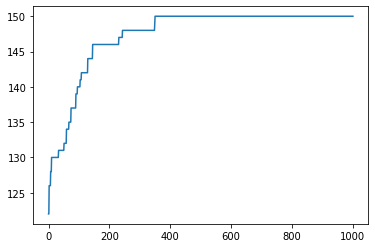

Poblacion inicial, best_fitness = 122
Best board found in 1.1316947937011719 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  460


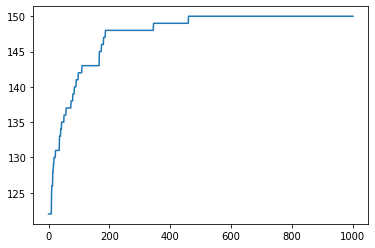

Poblacion inicial, best_fitness = 123
Best board found in 1.146259069442749 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  619


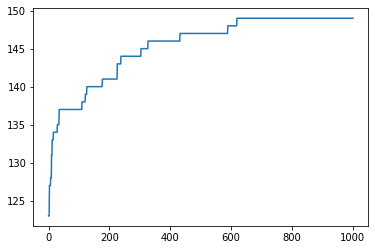

////////////////////////////////////////////////////////////
Taza de Mutacion:  0.3
Operador de Cruze:  multipoint
Modo de seleccion de padres:  tournament


Poblacion inicial, best_fitness = 123
Best board found in 1.0662407875061035 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  718


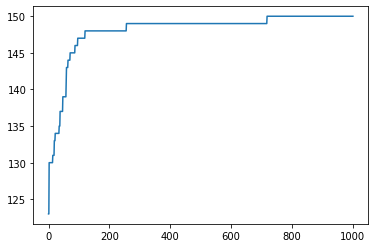

Poblacion inicial, best_fitness = 123
Best board found in 1.082244634628296 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  233


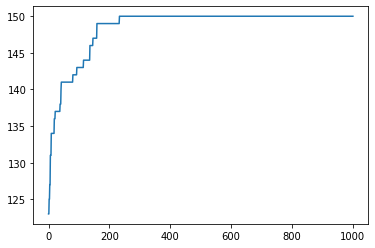

Poblacion inicial, best_fitness = 125
Best board found in 1.0772433280944824 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  334


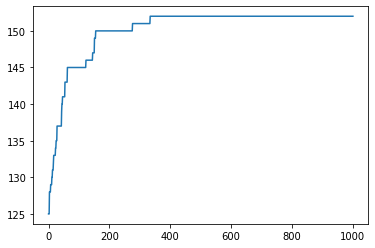

Poblacion inicial, best_fitness = 122
Best board found in 1.0702431201934814 seconds (1000 ierations) with 151/162 points:
Last Gen with improvement:  174


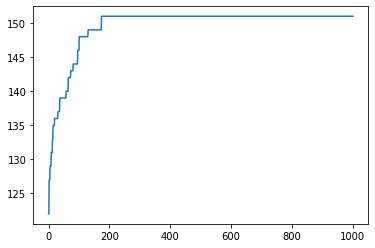

Poblacion inicial, best_fitness = 121
Best board found in 1.064239740371704 seconds (1000 ierations) with 154/162 points:
Last Gen with improvement:  420


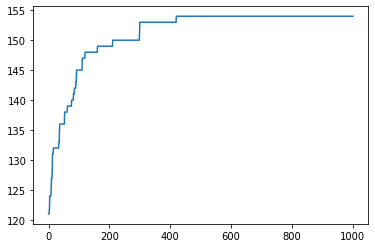

Poblacion inicial, best_fitness = 125
Best board found in 1.0662407875061035 seconds (1000 ierations) with 147/162 points:
Last Gen with improvement:  187


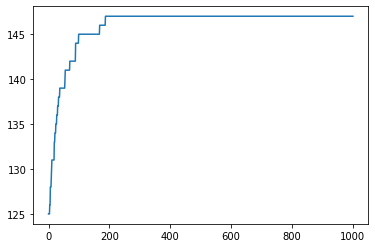

Poblacion inicial, best_fitness = 125
Best board found in 1.0592398643493652 seconds (1000 ierations) with 146/162 points:
Last Gen with improvement:  186


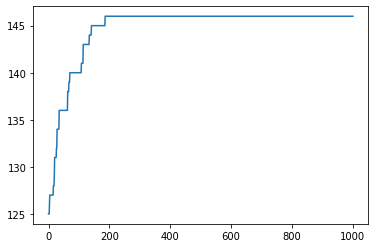

Poblacion inicial, best_fitness = 124
Best board found in 1.0482368469238281 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  141


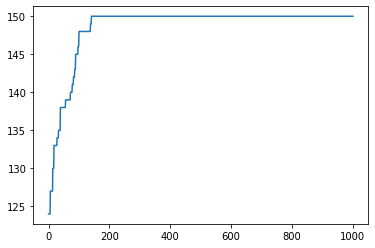

Poblacion inicial, best_fitness = 129
Best board found in 1.0782437324523926 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  210


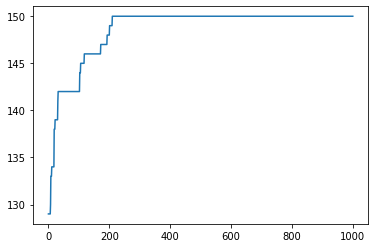

Poblacion inicial, best_fitness = 124
Best board found in 1.0483884811401367 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  337


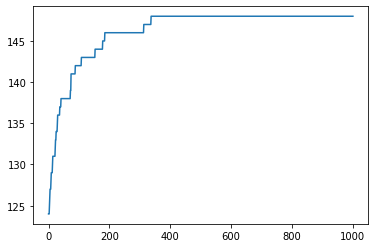

////////////////////////////////////////////////////////////
Taza de Mutacion:  0.3
Operador de Cruze:  orderpermutation
Modo de seleccion de padres:  tournament


Poblacion inicial, best_fitness = 127
Best board found in 1.0085890293121338 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  287


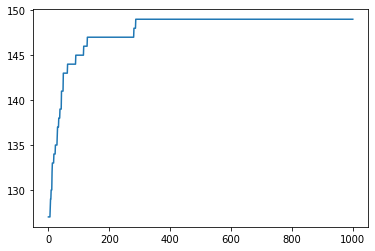

Poblacion inicial, best_fitness = 122
Best board found in 1.0114085674285889 seconds (1000 ierations) with 146/162 points:
Last Gen with improvement:  334


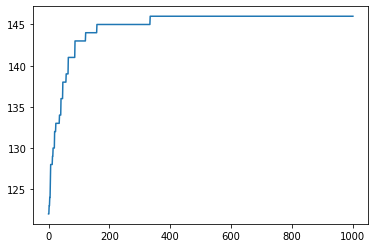

Poblacion inicial, best_fitness = 122
Best board found in 0.9993376731872559 seconds (1000 ierations) with 153/162 points:
Last Gen with improvement:  282


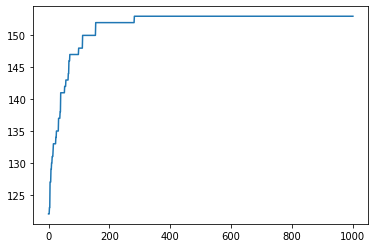

Poblacion inicial, best_fitness = 121
Best board found in 1.0072274208068848 seconds (1000 ierations) with 144/162 points:
Last Gen with improvement:  164


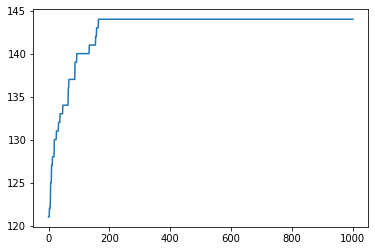

Poblacion inicial, best_fitness = 126
Best board found in 1.0150907039642334 seconds (1000 ierations) with 145/162 points:
Last Gen with improvement:  335


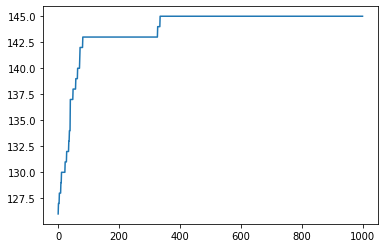

Poblacion inicial, best_fitness = 121
Best board found in 1.0280256271362305 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  176


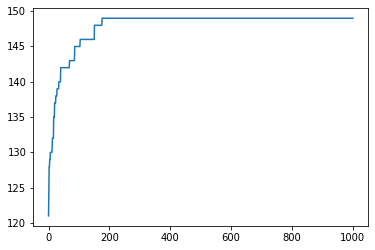

Poblacion inicial, best_fitness = 122
Best board found in 1.009721279144287 seconds (1000 ierations) with 146/162 points:
Last Gen with improvement:  268


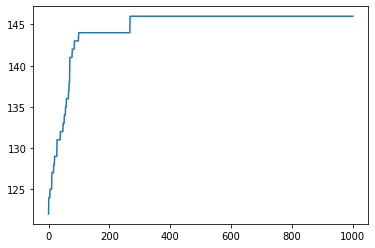

Poblacion inicial, best_fitness = 123
Best board found in 1.0099995136260986 seconds (1000 ierations) with 146/162 points:
Last Gen with improvement:  168


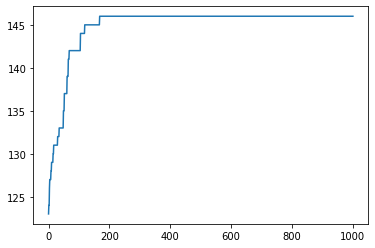

Poblacion inicial, best_fitness = 123
Best board found in 1.0070199966430664 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  110


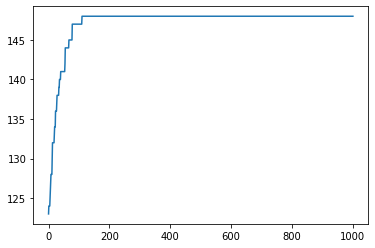

Poblacion inicial, best_fitness = 127
Best board found in 0.9970085620880127 seconds (1000 ierations) with 145/162 points:
Last Gen with improvement:  220


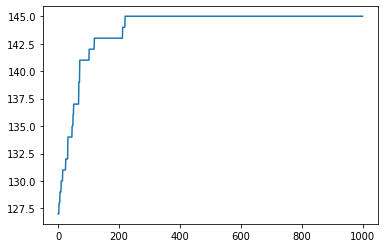

////////////////////////////////////////////////////////////
Taza de Mutacion:  0.3
Operador de Cruze:  PMXpermutation
Modo de seleccion de padres:  tournament


Poblacion inicial, best_fitness = 121
Best board found in 5.0107738971710205 seconds (1000 ierations) with 145/162 points:
Last Gen with improvement:  118


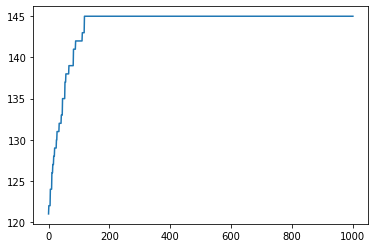

Poblacion inicial, best_fitness = 123
Best board found in 4.998128175735474 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  172


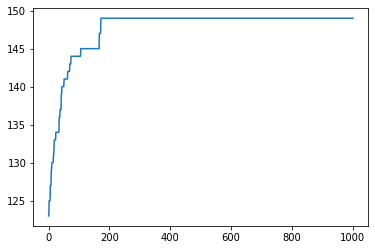

Poblacion inicial, best_fitness = 127
Best board found in 4.939624786376953 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  189


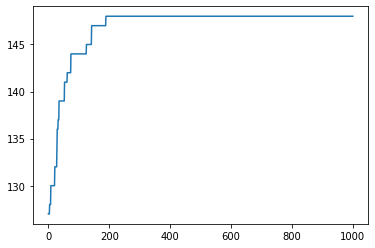

Poblacion inicial, best_fitness = 122
Best board found in 4.954119443893433 seconds (1000 ierations) with 147/162 points:
Last Gen with improvement:  868


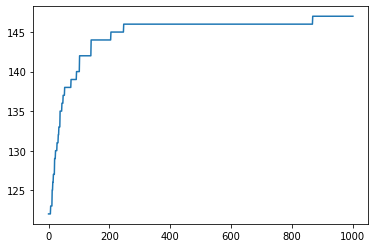

Poblacion inicial, best_fitness = 128
Best board found in 4.981815338134766 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  168


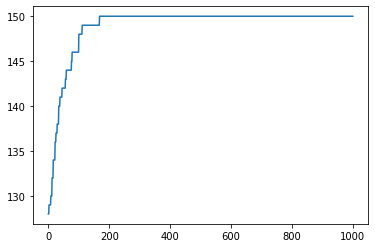

Poblacion inicial, best_fitness = 123
Best board found in 4.9589152336120605 seconds (1000 ierations) with 154/162 points:
Last Gen with improvement:  268


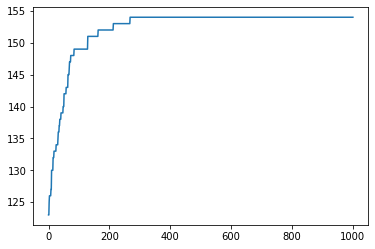

Poblacion inicial, best_fitness = 123
Best board found in 4.974123239517212 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  189


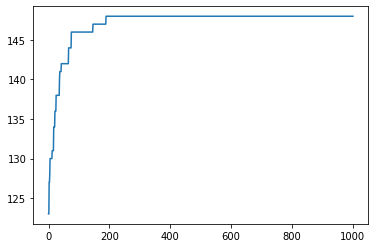

Poblacion inicial, best_fitness = 123
Best board found in 4.9481165409088135 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  269


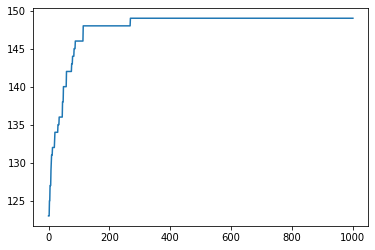

Poblacion inicial, best_fitness = 119
Best board found in 4.930113315582275 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  311


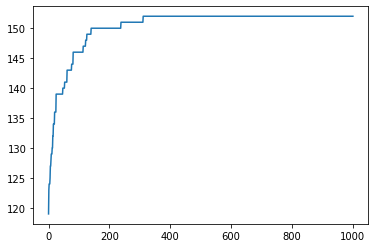

Poblacion inicial, best_fitness = 120
Best board found in 4.985470771789551 seconds (1000 ierations) with 151/162 points:
Last Gen with improvement:  223


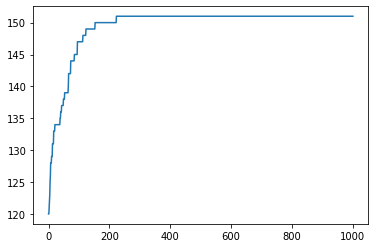

In [20]:
#generacion_fitness_mean_list=[]
#generacion_fitness_max_list=[]
#bestfitness_02a_max_mean_list=[]


pmut_index = pmut[2]
metodoSeleccionpadres_index = metodoSeleccionpadres[1]

gen_max_fitness_mean_list = []
max_fitness_mean_list = []


for crossover_index in crossover:

    print("/"*60)
    print("Taza de Mutacion: ", pmut_index)
    print("Operador de Cruze: ", crossover_index)
    print('Modo de seleccion de padres: ', metodoSeleccionpadres_index)
    print('\n')

    gen_max_fitness_list = []
    max_fitness_list = []

    for i in range(0,10):
        population = init_population(num_individuals, board, initialEntries)
        best_ind, bestfitness, gen_max_fitness, max_fitness = genetic_algorithm(population, fitness_fn, ngen = ngen,
                                                  pmut = pmut_index,
                                                  pcx = pcx,
                                                  tournament_size = tournament_size, 
                                                  crossover = crossover_index,
                                                  mutation = mutation[0],
                                                  selection_parents_method = metodoSeleccionpadres_index,
                                                  selection_survivors_method = metodoSeleccionsobrevivientes[0])
        plt.plot(bestfitness)
        plt.show()

        gen_max_fitness_list.append(gen_max_fitness)
        max_fitness_list.append(max_fitness)



    gen_max_fitness_array=np.asarray(gen_max_fitness_list)
    max_fitness_array=np.asarray(max_fitness_list)
    gen_max_fitness_mean=np.mean(gen_max_fitness_array)
    max_fitness_mean=np.mean(max_fitness_array)

    gen_max_fitness_mean_list.append(gen_max_fitness_mean)
    max_fitness_mean_list.append(max_fitness_mean)



                

<function matplotlib.pyplot.show(close=None, block=None)>

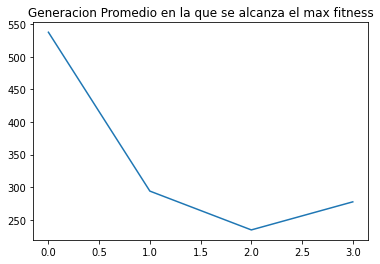

In [21]:
plt.plot(gen_max_fitness_mean_list)
plt.title('Generacion Promedio en la que se alcanza el max fitness')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

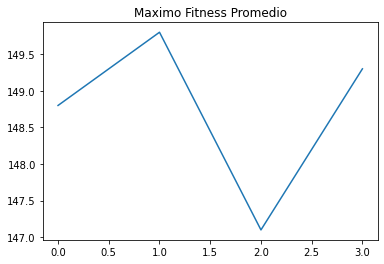

In [22]:
plt.plot(max_fitness_mean_list)
plt.title('Maximo Fitness Promedio')
plt.show

////////////////////////////////////////////////////////////
Taza de Mutacion:  0.5
Operador de Cruze:  onepoint
Modo de seleccion de padres:  tournament


Poblacion inicial, best_fitness = 121
Best board found in 1.4920809268951416 seconds (1000 ierations) with 151/162 points:
Last Gen with improvement:  186


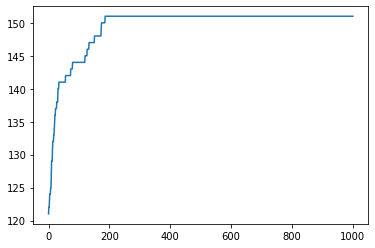

Poblacion inicial, best_fitness = 123
Best board found in 1.4954516887664795 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  205


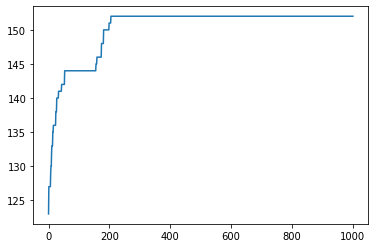

Poblacion inicial, best_fitness = 123
Best board found in 1.4913365840911865 seconds (1000 ierations) with 151/162 points:
Last Gen with improvement:  201


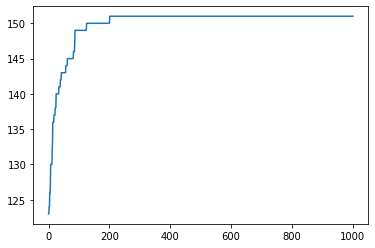

Poblacion inicial, best_fitness = 120
Best board found in 1.4873881340026855 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  159


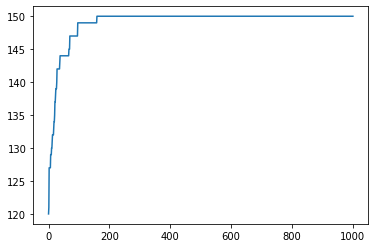

Poblacion inicial, best_fitness = 127
Best board found in 1.4943373203277588 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  429


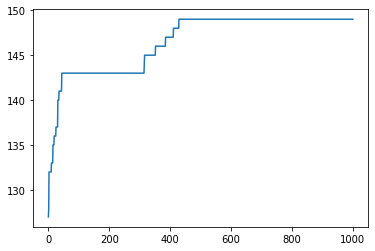

Poblacion inicial, best_fitness = 123
Best board found in 1.4933364391326904 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  205


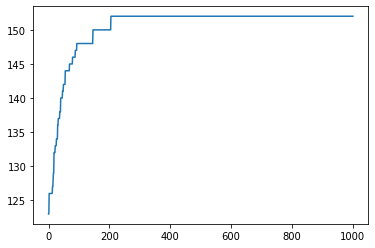

Poblacion inicial, best_fitness = 125
Best board found in 1.4943411350250244 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  300


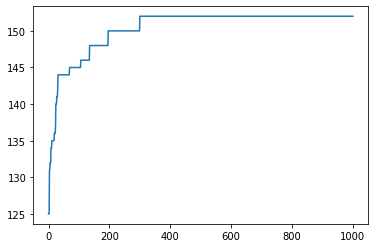

Poblacion inicial, best_fitness = 124
Best board found in 1.5033400058746338 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  675


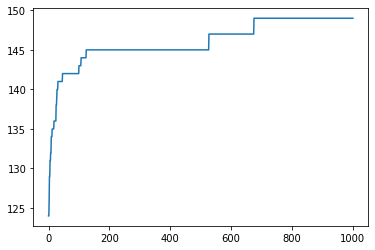

Poblacion inicial, best_fitness = 124
Best board found in 1.4823341369628906 seconds (1000 ierations) with 154/162 points:
Last Gen with improvement:  215


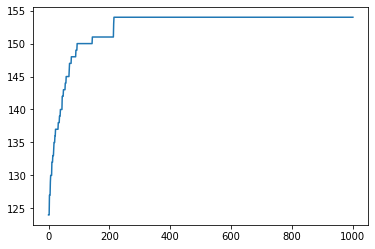

Poblacion inicial, best_fitness = 123
Best board found in 1.4883363246917725 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  142


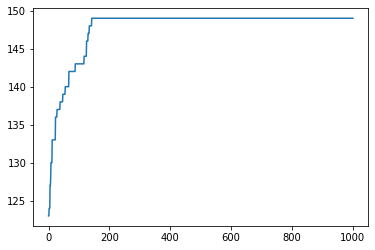

////////////////////////////////////////////////////////////
Taza de Mutacion:  0.5
Operador de Cruze:  multipoint
Modo de seleccion de padres:  tournament


Poblacion inicial, best_fitness = 117
Best board found in 1.4373247623443604 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  200


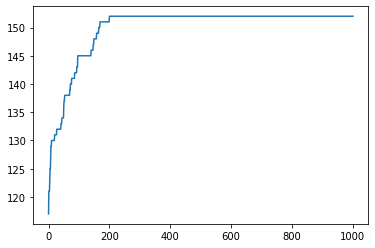

Poblacion inicial, best_fitness = 127
Best board found in 1.4483270645141602 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  132


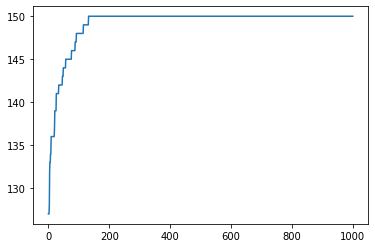

Poblacion inicial, best_fitness = 126
Best board found in 1.4283223152160645 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  286


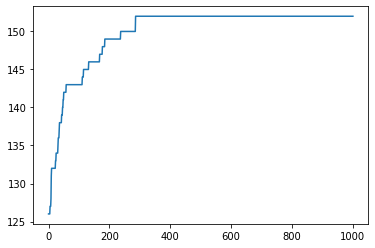

Poblacion inicial, best_fitness = 124
Best board found in 1.4293227195739746 seconds (1000 ierations) with 146/162 points:
Last Gen with improvement:  89


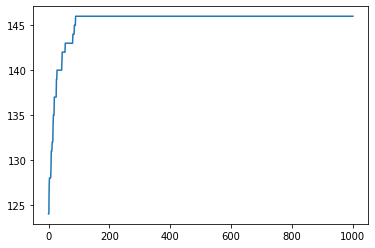

Poblacion inicial, best_fitness = 124
Best board found in 1.4378292560577393 seconds (1000 ierations) with 153/162 points:
Last Gen with improvement:  123


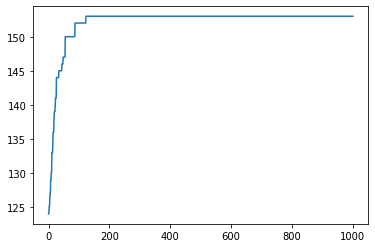

Poblacion inicial, best_fitness = 122
Best board found in 1.4308207035064697 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  215


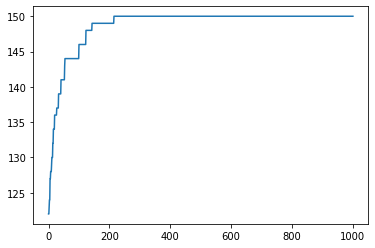

Poblacion inicial, best_fitness = 126
Best board found in 1.4239983558654785 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  303


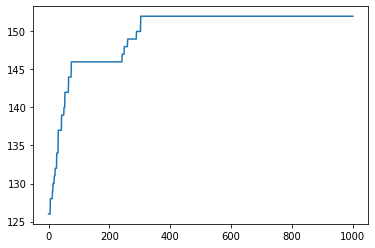

Poblacion inicial, best_fitness = 124
Best board found in 1.442011833190918 seconds (1000 ierations) with 151/162 points:
Last Gen with improvement:  61


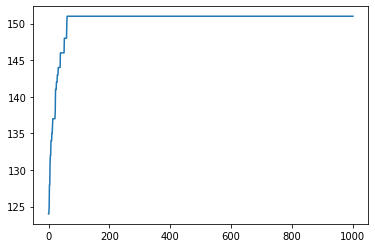

Poblacion inicial, best_fitness = 128
Best board found in 1.4201698303222656 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  147


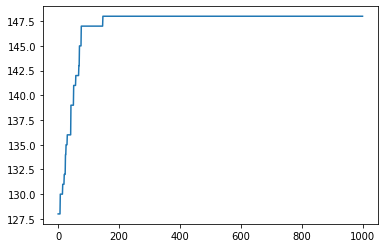

Poblacion inicial, best_fitness = 122
Best board found in 1.4183194637298584 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  525


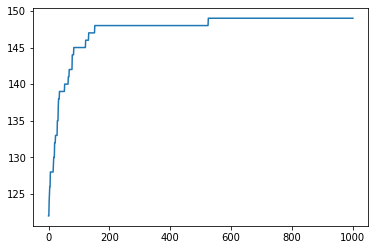

////////////////////////////////////////////////////////////
Taza de Mutacion:  0.5
Operador de Cruze:  orderpermutation
Modo de seleccion de padres:  tournament


Poblacion inicial, best_fitness = 128
Best board found in 1.370136022567749 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  161


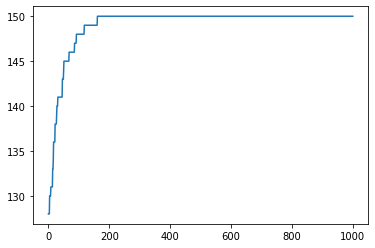

Poblacion inicial, best_fitness = 122
Best board found in 1.3633317947387695 seconds (1000 ierations) with 151/162 points:
Last Gen with improvement:  251


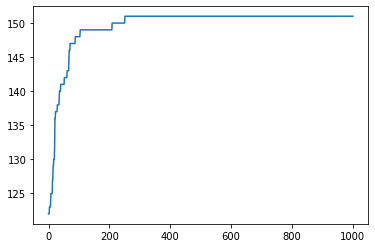

Poblacion inicial, best_fitness = 124
Best board found in 1.370126485824585 seconds (1000 ierations) with 147/162 points:
Last Gen with improvement:  92


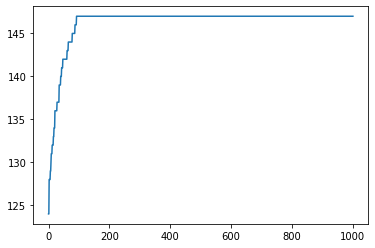

Poblacion inicial, best_fitness = 123
Best board found in 1.360307216644287 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  190


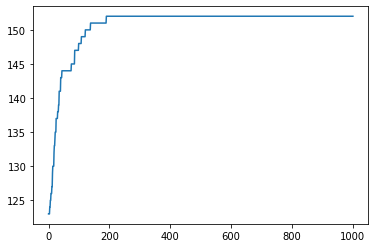

Poblacion inicial, best_fitness = 122
Best board found in 1.3483047485351562 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  717


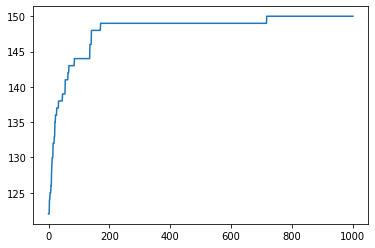

Poblacion inicial, best_fitness = 125
Best board found in 1.3763113021850586 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  145


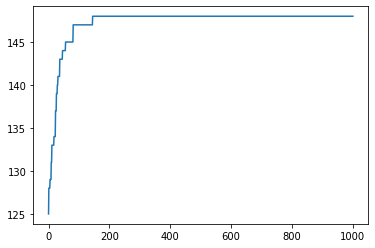

Poblacion inicial, best_fitness = 124
Best board found in 1.372309923171997 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  100


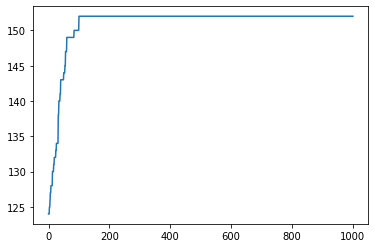

Poblacion inicial, best_fitness = 122
Best board found in 1.369774580001831 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  214


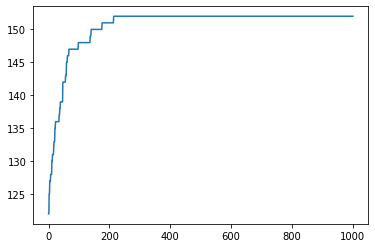

Poblacion inicial, best_fitness = 126
Best board found in 1.3683090209960938 seconds (1000 ierations) with 145/162 points:
Last Gen with improvement:  124


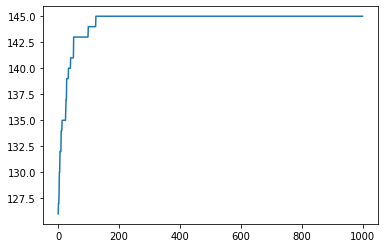

Poblacion inicial, best_fitness = 123
Best board found in 1.360307216644287 seconds (1000 ierations) with 153/162 points:
Last Gen with improvement:  228


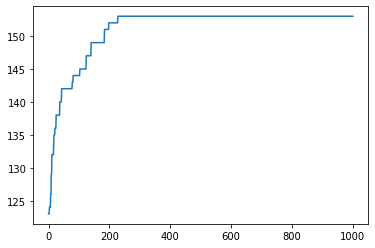

////////////////////////////////////////////////////////////
Taza de Mutacion:  0.5
Operador de Cruze:  PMXpermutation
Modo de seleccion de padres:  tournament


Poblacion inicial, best_fitness = 127
Best board found in 5.330340623855591 seconds (1000 ierations) with 151/162 points:
Last Gen with improvement:  250


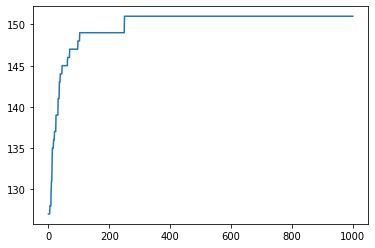

Poblacion inicial, best_fitness = 121
Best board found in 5.287536859512329 seconds (1000 ierations) with 151/162 points:
Last Gen with improvement:  113


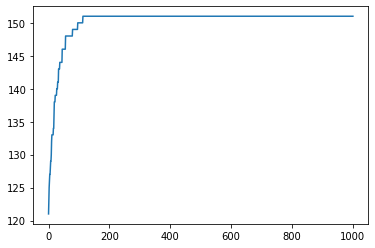

Poblacion inicial, best_fitness = 123
Best board found in 5.348412752151489 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  226


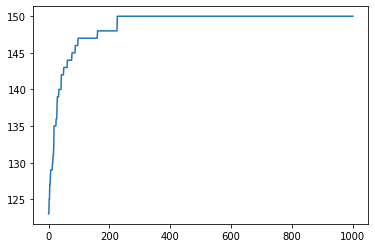

Poblacion inicial, best_fitness = 126
Best board found in 5.308924436569214 seconds (1000 ierations) with 153/162 points:
Last Gen with improvement:  151


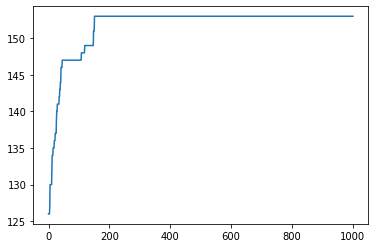

Poblacion inicial, best_fitness = 121
Best board found in 5.299196720123291 seconds (1000 ierations) with 153/162 points:
Last Gen with improvement:  168


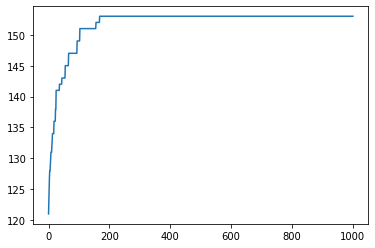

Poblacion inicial, best_fitness = 124
Best board found in 5.319201469421387 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  96


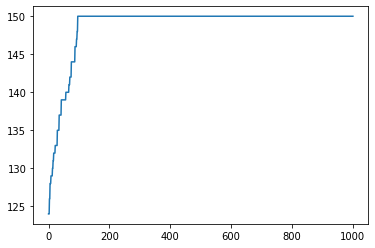

Poblacion inicial, best_fitness = 124
Best board found in 5.2922303676605225 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  177


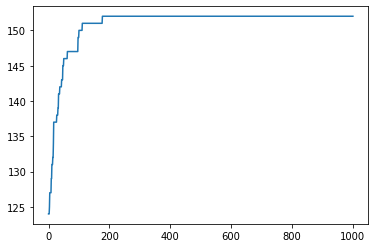

Poblacion inicial, best_fitness = 126
Best board found in 5.287798166275024 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  75


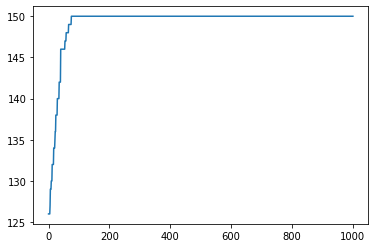

Poblacion inicial, best_fitness = 128
Best board found in 5.347452878952026 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  83


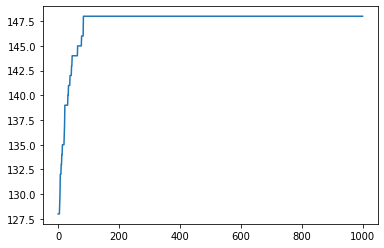

Poblacion inicial, best_fitness = 121
Best board found in 5.3562095165252686 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  123


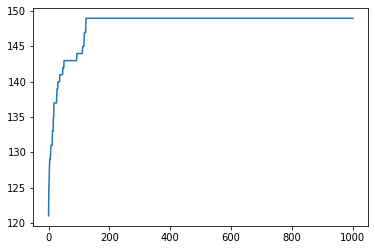

In [23]:
#generacion_fitness_mean_list=[]
#generacion_fitness_max_list=[]
#bestfitness_02a_max_mean_list=[]


pmut_index = pmut[3]
metodoSeleccionpadres_index = metodoSeleccionpadres[1]

gen_max_fitness_mean_list = []
max_fitness_mean_list = []


for crossover_index in crossover:

    print("/"*60)
    print("Taza de Mutacion: ", pmut_index)
    print("Operador de Cruze: ", crossover_index)
    print('Modo de seleccion de padres: ', metodoSeleccionpadres_index)
    print('\n')

    gen_max_fitness_list = []
    max_fitness_list = []

    for i in range(0,10):
        population = init_population(num_individuals, board, initialEntries)
        best_ind, bestfitness, gen_max_fitness, max_fitness = genetic_algorithm(population, fitness_fn, ngen = ngen,
                                                  pmut = pmut_index,
                                                  pcx = pcx,
                                                  tournament_size = tournament_size, 
                                                  crossover = crossover_index,
                                                  mutation = mutation[0],
                                                  selection_parents_method = metodoSeleccionpadres_index,
                                                  selection_survivors_method = metodoSeleccionsobrevivientes[0])
        plt.plot(bestfitness)
        plt.show()

        gen_max_fitness_list.append(gen_max_fitness)
        max_fitness_list.append(max_fitness)



    gen_max_fitness_array=np.asarray(gen_max_fitness_list)
    max_fitness_array=np.asarray(max_fitness_list)
    gen_max_fitness_mean=np.mean(gen_max_fitness_array)
    max_fitness_mean=np.mean(max_fitness_array)

    gen_max_fitness_mean_list.append(gen_max_fitness_mean)
    max_fitness_mean_list.append(max_fitness_mean)



                

<function matplotlib.pyplot.show(close=None, block=None)>

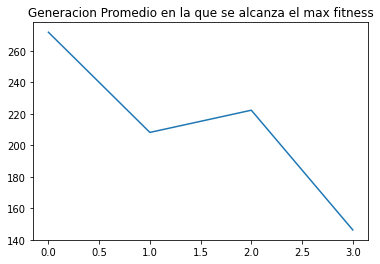

In [24]:
plt.plot(gen_max_fitness_mean_list)
plt.title('Generacion Promedio en la que se alcanza el max fitness')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

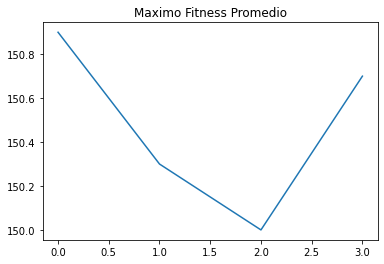

In [25]:
plt.plot(max_fitness_mean_list)
plt.title('Maximo Fitness Promedio')
plt.show

////////////////////////////////////////////////////////////
Taza de Mutacion:  0.2
Operador de Cruze:  onepoint
Modo de seleccion de padres:  random


Poblacion inicial, best_fitness = 119
Best board found in 0.9122059345245361 seconds (1000 ierations) with 144/162 points:
Last Gen with improvement:  964


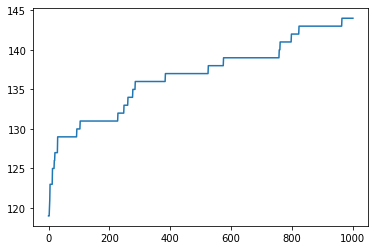

Poblacion inicial, best_fitness = 126
Best board found in 0.8892006874084473 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  929


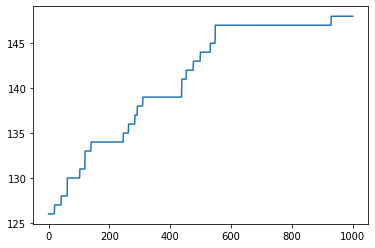

Poblacion inicial, best_fitness = 122
Best board found in 0.8892006874084473 seconds (1000 ierations) with 146/162 points:
Last Gen with improvement:  480


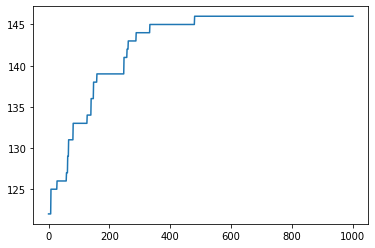

Poblacion inicial, best_fitness = 124
Best board found in 0.8922019004821777 seconds (1000 ierations) with 147/162 points:
Last Gen with improvement:  404


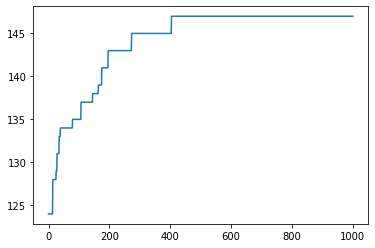

Poblacion inicial, best_fitness = 122
Best board found in 0.9102046489715576 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  466


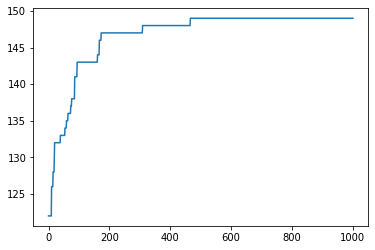

Poblacion inicial, best_fitness = 128
Best board found in 0.9182071685791016 seconds (1000 ierations) with 151/162 points:
Last Gen with improvement:  921


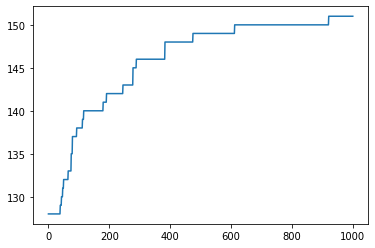

Poblacion inicial, best_fitness = 124
Best board found in 0.9262089729309082 seconds (1000 ierations) with 151/162 points:
Last Gen with improvement:  434


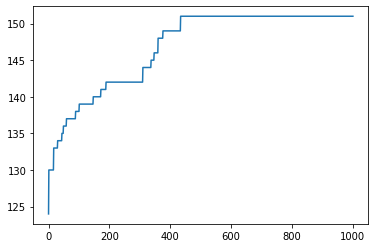

Poblacion inicial, best_fitness = 122
Best board found in 0.9252095222473145 seconds (1000 ierations) with 145/162 points:
Last Gen with improvement:  517


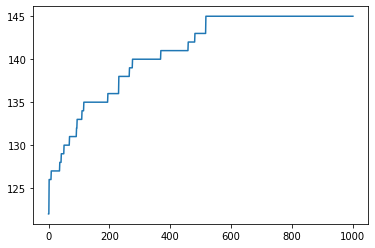

Poblacion inicial, best_fitness = 123
Best board found in 0.9051237106323242 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  276


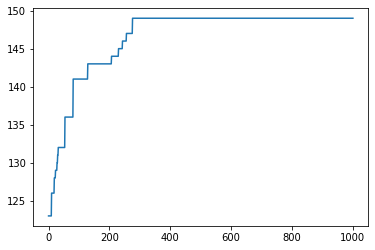

Poblacion inicial, best_fitness = 123
Best board found in 0.8968691825866699 seconds (1000 ierations) with 146/162 points:
Last Gen with improvement:  943


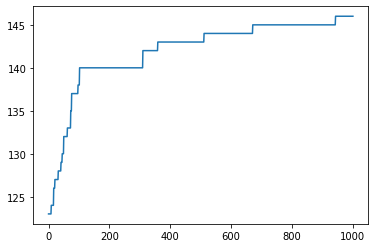

////////////////////////////////////////////////////////////
Taza de Mutacion:  0.2
Operador de Cruze:  multipoint
Modo de seleccion de padres:  random


Poblacion inicial, best_fitness = 123
Best board found in 0.8671953678131104 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  319


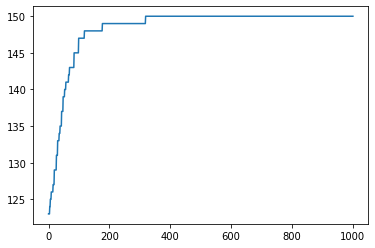

Poblacion inicial, best_fitness = 124
Best board found in 0.8193526268005371 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  345


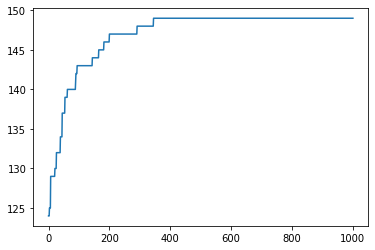

Poblacion inicial, best_fitness = 123
Best board found in 0.850147008895874 seconds (1000 ierations) with 151/162 points:
Last Gen with improvement:  254


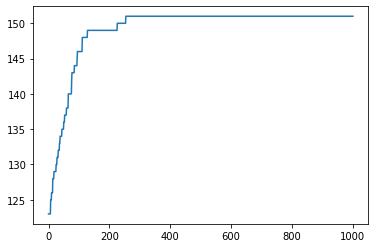

Poblacion inicial, best_fitness = 123
Best board found in 0.8578481674194336 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  459


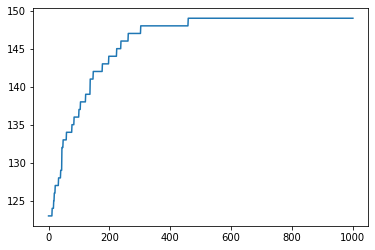

Poblacion inicial, best_fitness = 122
Best board found in 0.8051819801330566 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  526


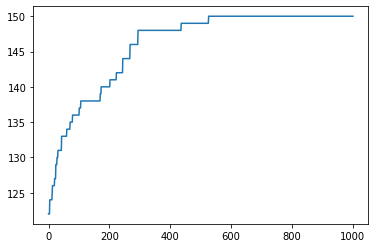

Poblacion inicial, best_fitness = 128
Best board found in 0.8551928997039795 seconds (1000 ierations) with 146/162 points:
Last Gen with improvement:  265


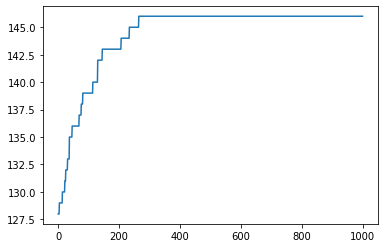

Poblacion inicial, best_fitness = 122
Best board found in 0.858116626739502 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  541


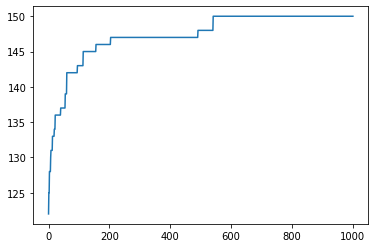

Poblacion inicial, best_fitness = 125
Best board found in 0.8517975807189941 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  279


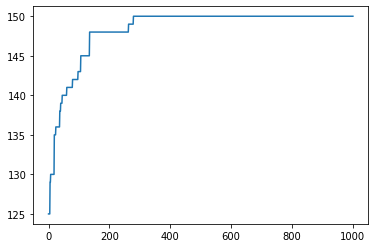

Poblacion inicial, best_fitness = 120
Best board found in 0.8201851844787598 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  274


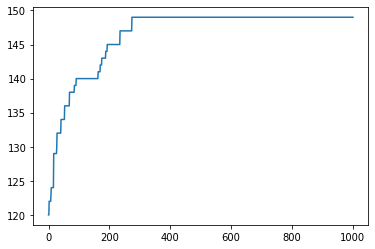

Poblacion inicial, best_fitness = 119
Best board found in 0.8641958236694336 seconds (1000 ierations) with 145/162 points:
Last Gen with improvement:  314


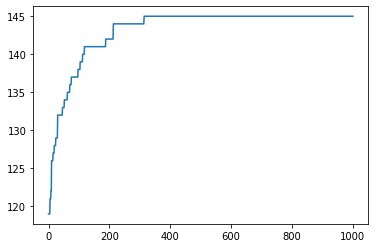

////////////////////////////////////////////////////////////
Taza de Mutacion:  0.2
Operador de Cruze:  orderpermutation
Modo de seleccion de padres:  random


Poblacion inicial, best_fitness = 125
Best board found in 0.7811770439147949 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  472


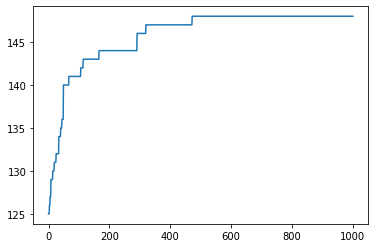

Poblacion inicial, best_fitness = 128
Best board found in 0.7791759967803955 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  410


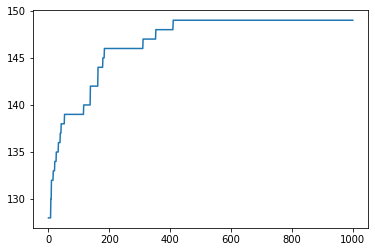

Poblacion inicial, best_fitness = 124
Best board found in 0.7546737194061279 seconds (1000 ierations) with 143/162 points:
Last Gen with improvement:  108


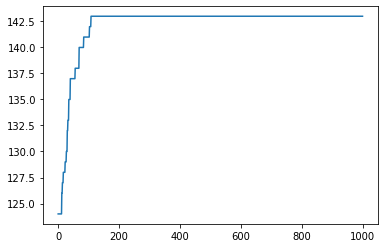

Poblacion inicial, best_fitness = 122
Best board found in 0.7911796569824219 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  395


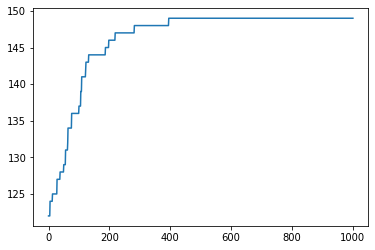

Poblacion inicial, best_fitness = 122
Best board found in 0.7841765880584717 seconds (1000 ierations) with 151/162 points:
Last Gen with improvement:  439


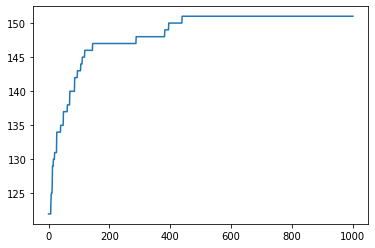

Poblacion inicial, best_fitness = 123
Best board found in 0.7901792526245117 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  183


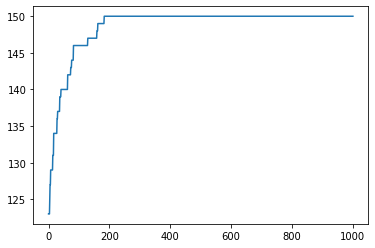

Poblacion inicial, best_fitness = 123
Best board found in 0.7881786823272705 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  546


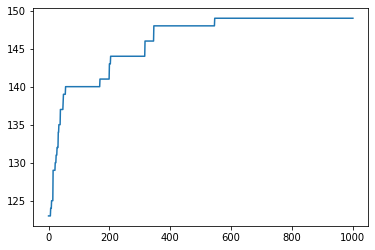

Poblacion inicial, best_fitness = 123
Best board found in 0.7471685409545898 seconds (1000 ierations) with 153/162 points:
Last Gen with improvement:  802


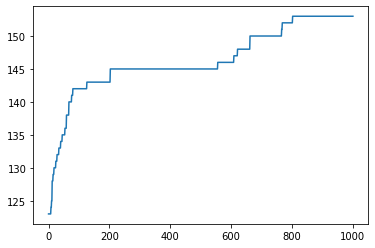

Poblacion inicial, best_fitness = 122
Best board found in 0.7931795120239258 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  387


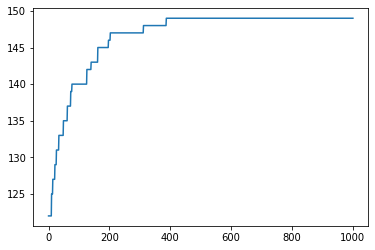

Poblacion inicial, best_fitness = 123
Best board found in 0.7831766605377197 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  338


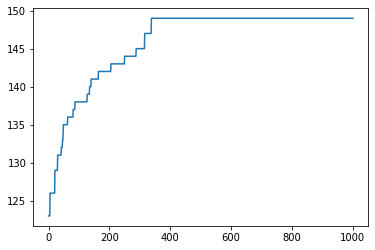

////////////////////////////////////////////////////////////
Taza de Mutacion:  0.2
Operador de Cruze:  PMXpermutation
Modo de seleccion de padres:  random


Poblacion inicial, best_fitness = 122
Best board found in 5.178169250488281 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  420


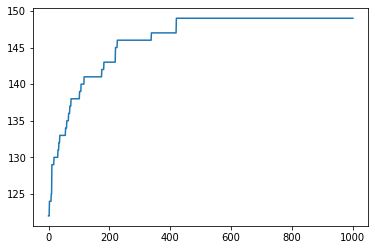

Poblacion inicial, best_fitness = 124
Best board found in 4.989929914474487 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  236


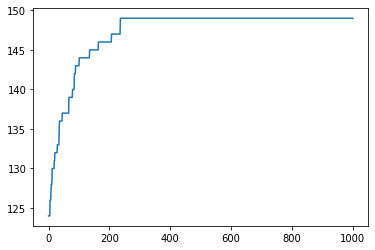

Poblacion inicial, best_fitness = 123
Best board found in 4.913054943084717 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  348


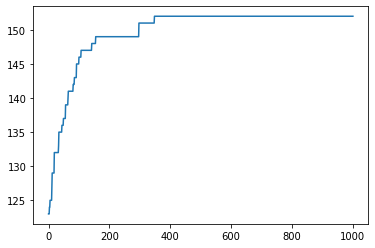

Poblacion inicial, best_fitness = 121
Best board found in 4.821971893310547 seconds (1000 ierations) with 151/162 points:
Last Gen with improvement:  279


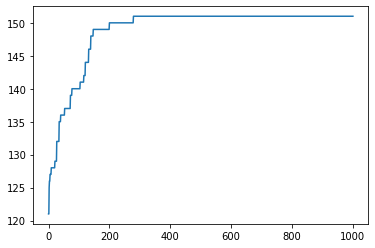

Poblacion inicial, best_fitness = 124
Best board found in 4.967859268188477 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  442


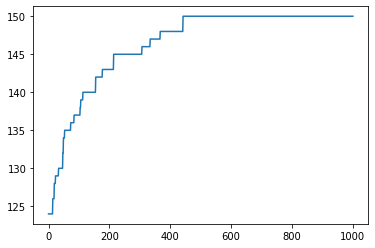

Poblacion inicial, best_fitness = 125
Best board found in 5.072818994522095 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  496


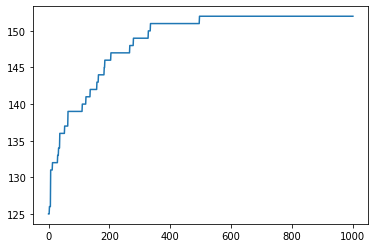

Poblacion inicial, best_fitness = 121
Best board found in 4.890672445297241 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  415


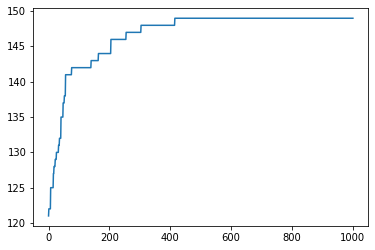

Poblacion inicial, best_fitness = 121
Best board found in 5.029548406600952 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  497


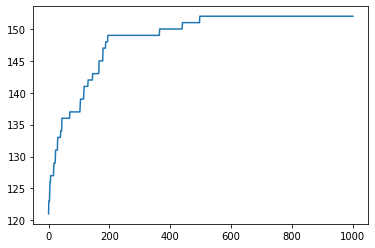

Poblacion inicial, best_fitness = 126
Best board found in 5.160165548324585 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  202


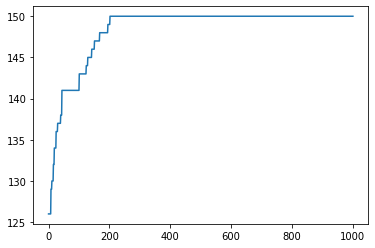

Poblacion inicial, best_fitness = 124
Best board found in 4.947117567062378 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  325


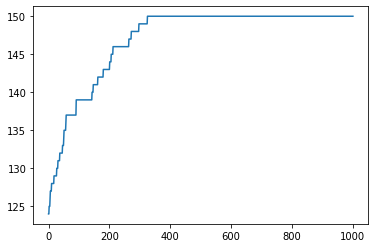

In [26]:
#generacion_fitness_mean_list=[]
#generacion_fitness_max_list=[]
#bestfitness_02a_max_mean_list=[]


pmut_index = pmut[1]
metodoSeleccionpadres_index = metodoSeleccionpadres[2]

gen_max_fitness_mean_list = []
max_fitness_mean_list = []


for crossover_index in crossover:

    print("/"*60)
    print("Taza de Mutacion: ", pmut_index)
    print("Operador de Cruze: ", crossover_index)
    print('Modo de seleccion de padres: ', metodoSeleccionpadres_index)
    print('\n')

    gen_max_fitness_list = []
    max_fitness_list = []

    for i in range(0,10):
        population = init_population(num_individuals, board, initialEntries)
        best_ind, bestfitness, gen_max_fitness, max_fitness = genetic_algorithm(population, fitness_fn, ngen = ngen,
                                                  pmut = pmut_index,
                                                  pcx = pcx,
                                                  tournament_size = tournament_size, 
                                                  crossover = crossover_index,
                                                  mutation = mutation[0],
                                                  selection_parents_method = metodoSeleccionpadres_index,
                                                  selection_survivors_method = metodoSeleccionsobrevivientes[0])
        plt.plot(bestfitness)
        plt.show()

        gen_max_fitness_list.append(gen_max_fitness)
        max_fitness_list.append(max_fitness)



    gen_max_fitness_array=np.asarray(gen_max_fitness_list)
    max_fitness_array=np.asarray(max_fitness_list)
    gen_max_fitness_mean=np.mean(gen_max_fitness_array)
    max_fitness_mean=np.mean(max_fitness_array)

    gen_max_fitness_mean_list.append(gen_max_fitness_mean)
    max_fitness_mean_list.append(max_fitness_mean)



                

<function matplotlib.pyplot.show(close=None, block=None)>

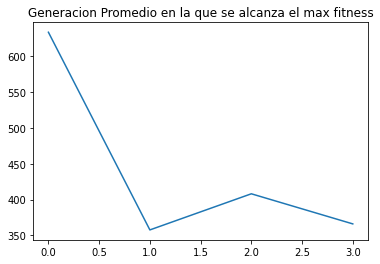

In [27]:
plt.plot(gen_max_fitness_mean_list)
plt.title('Generacion Promedio en la que se alcanza el max fitness')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

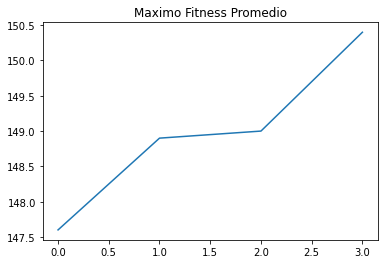

In [28]:
plt.plot(max_fitness_mean_list)
plt.title('Maximo Fitness Promedio')
plt.show

////////////////////////////////////////////////////////////
Taza de Mutacion:  0.3
Operador de Cruze:  onepoint
Modo de seleccion de padres:  random


Poblacion inicial, best_fitness = 125
Best board found in 1.1252539157867432 seconds (1000 ierations) with 151/162 points:
Last Gen with improvement:  563


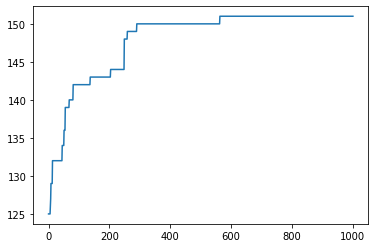

Poblacion inicial, best_fitness = 123
Best board found in 1.0512373447418213 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  629


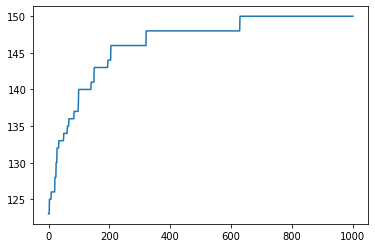

Poblacion inicial, best_fitness = 133
Best board found in 1.071241855621338 seconds (1000 ierations) with 147/162 points:
Last Gen with improvement:  700


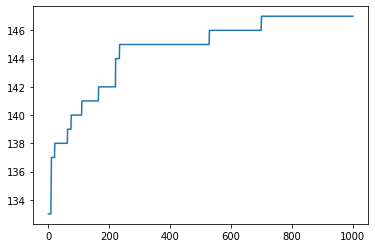

Poblacion inicial, best_fitness = 124
Best board found in 1.0652406215667725 seconds (1000 ierations) with 146/162 points:
Last Gen with improvement:  619


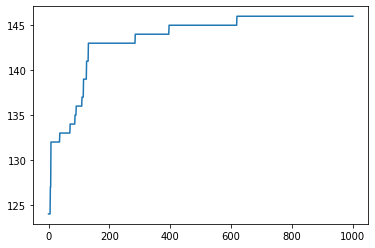

Poblacion inicial, best_fitness = 127
Best board found in 1.0762429237365723 seconds (1000 ierations) with 147/162 points:
Last Gen with improvement:  507


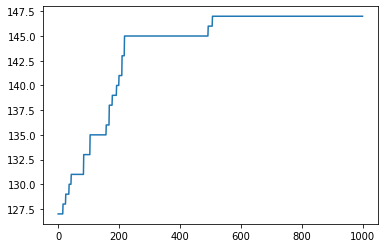

Poblacion inicial, best_fitness = 124
Best board found in 1.0915849208831787 seconds (1000 ierations) with 151/162 points:
Last Gen with improvement:  601


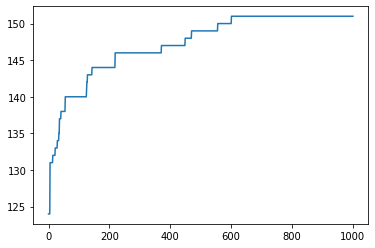

Poblacion inicial, best_fitness = 120
Best board found in 1.075242519378662 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  464


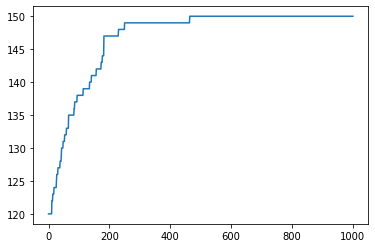

Poblacion inicial, best_fitness = 119
Best board found in 1.091459035873413 seconds (1000 ierations) with 146/162 points:
Last Gen with improvement:  664


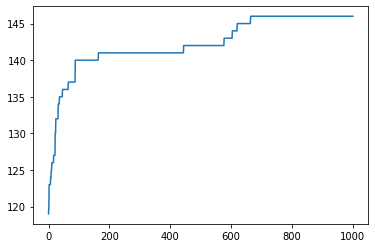

Poblacion inicial, best_fitness = 119
Best board found in 1.066925048828125 seconds (1000 ierations) with 147/162 points:
Last Gen with improvement:  473


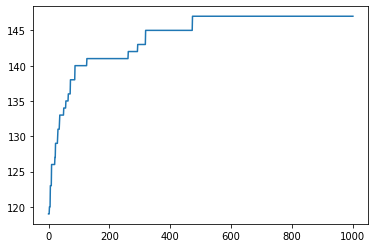

Poblacion inicial, best_fitness = 122
Best board found in 1.1272547245025635 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  557


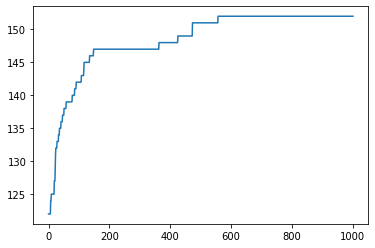

////////////////////////////////////////////////////////////
Taza de Mutacion:  0.3
Operador de Cruze:  multipoint
Modo de seleccion de padres:  random


Poblacion inicial, best_fitness = 128
Best board found in 1.0690853595733643 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  834


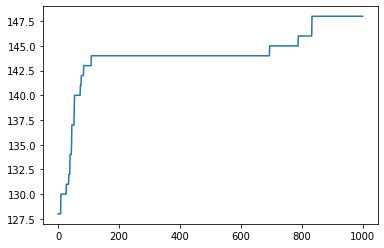

Poblacion inicial, best_fitness = 124
Best board found in 1.0789413452148438 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  494


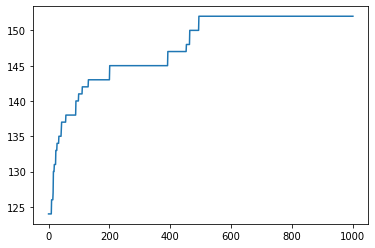

Poblacion inicial, best_fitness = 124
Best board found in 1.047053337097168 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  730


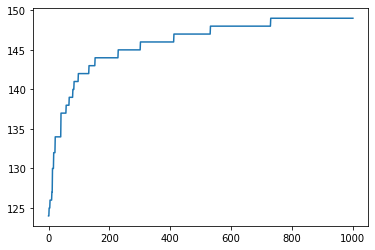

Poblacion inicial, best_fitness = 123
Best board found in 1.044877529144287 seconds (1000 ierations) with 154/162 points:
Last Gen with improvement:  326


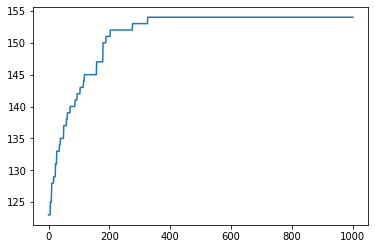

Poblacion inicial, best_fitness = 126
Best board found in 1.0782432556152344 seconds (1000 ierations) with 146/162 points:
Last Gen with improvement:  761


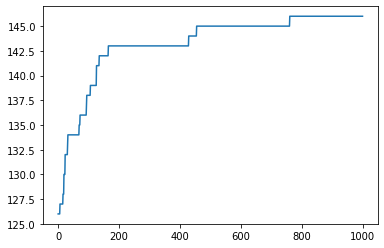

Poblacion inicial, best_fitness = 120
Best board found in 1.037463903427124 seconds (1000 ierations) with 147/162 points:
Last Gen with improvement:  188


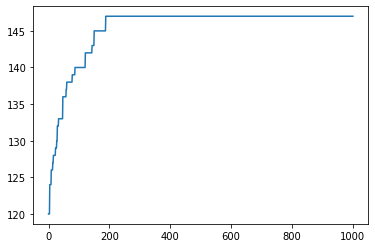

Poblacion inicial, best_fitness = 120
Best board found in 1.0704679489135742 seconds (1000 ierations) with 156/162 points:
Last Gen with improvement:  270


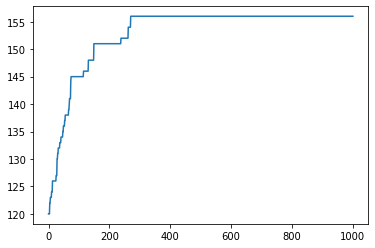

Poblacion inicial, best_fitness = 123
Best board found in 1.071241855621338 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  281


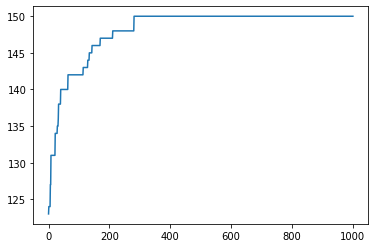

Poblacion inicial, best_fitness = 123
Best board found in 1.0442357063293457 seconds (1000 ierations) with 151/162 points:
Last Gen with improvement:  508


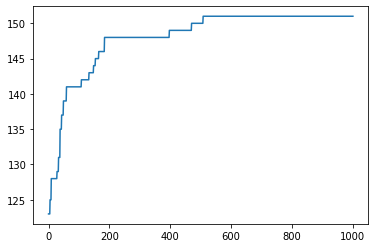

Poblacion inicial, best_fitness = 125
Best board found in 1.0782432556152344 seconds (1000 ierations) with 151/162 points:
Last Gen with improvement:  174


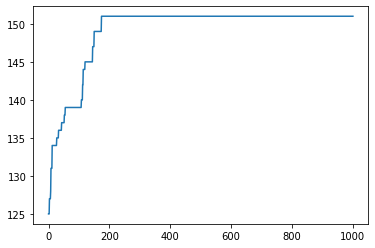

////////////////////////////////////////////////////////////
Taza de Mutacion:  0.3
Operador de Cruze:  orderpermutation
Modo de seleccion de padres:  random


Poblacion inicial, best_fitness = 122
Best board found in 1.0172297954559326 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  205


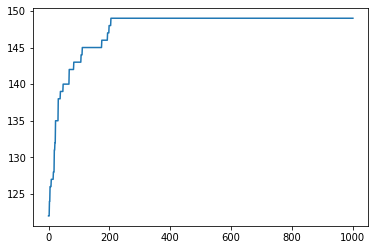

Poblacion inicial, best_fitness = 123
Best board found in 0.9542160034179688 seconds (1000 ierations) with 146/162 points:
Last Gen with improvement:  203


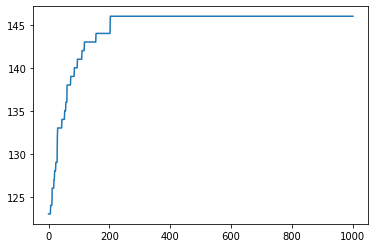

Poblacion inicial, best_fitness = 120
Best board found in 0.9542157649993896 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  340


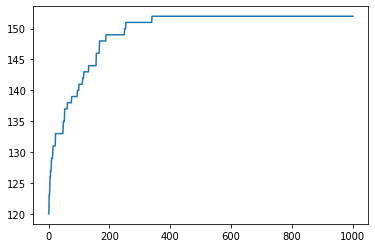

Poblacion inicial, best_fitness = 125
Best board found in 0.9772534370422363 seconds (1000 ierations) with 153/162 points:
Last Gen with improvement:  209


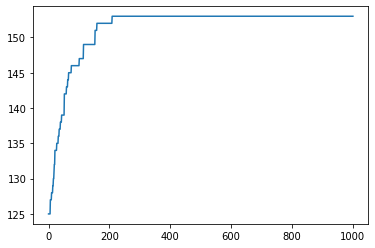

Poblacion inicial, best_fitness = 124
Best board found in 0.9802215099334717 seconds (1000 ierations) with 140/162 points:
Last Gen with improvement:  104


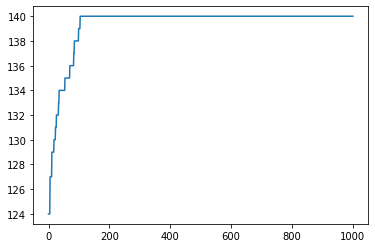

Poblacion inicial, best_fitness = 123
Best board found in 1.009227991104126 seconds (1000 ierations) with 146/162 points:
Last Gen with improvement:  179


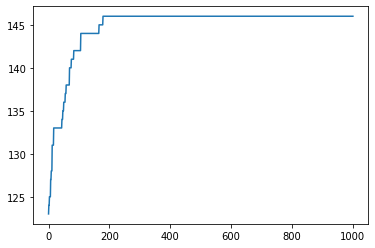

Poblacion inicial, best_fitness = 118
Best board found in 1.020230770111084 seconds (1000 ierations) with 147/162 points:
Last Gen with improvement:  168


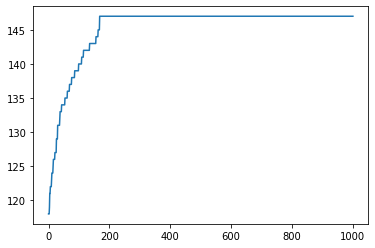

Poblacion inicial, best_fitness = 127
Best board found in 0.9812214374542236 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  252


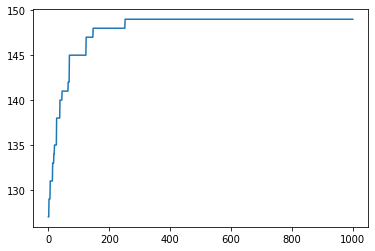

Poblacion inicial, best_fitness = 122
Best board found in 1.0012261867523193 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  172


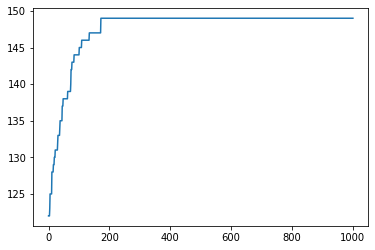

Poblacion inicial, best_fitness = 127
Best board found in 0.9952249526977539 seconds (1000 ierations) with 151/162 points:
Last Gen with improvement:  268


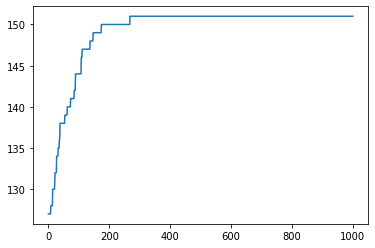

////////////////////////////////////////////////////////////
Taza de Mutacion:  0.3
Operador de Cruze:  PMXpermutation
Modo de seleccion de padres:  random


Poblacion inicial, best_fitness = 122
Best board found in 5.514480352401733 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  207


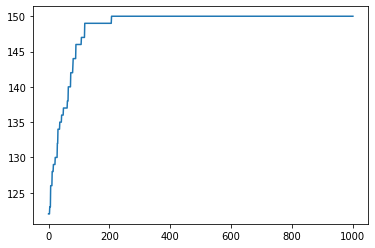

Poblacion inicial, best_fitness = 125
Best board found in 5.092079162597656 seconds (1000 ierations) with 151/162 points:
Last Gen with improvement:  173


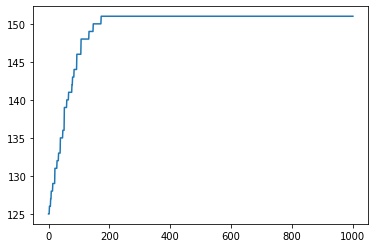

Poblacion inicial, best_fitness = 122
Best board found in 5.041062116622925 seconds (1000 ierations) with 156/162 points:
Last Gen with improvement:  490


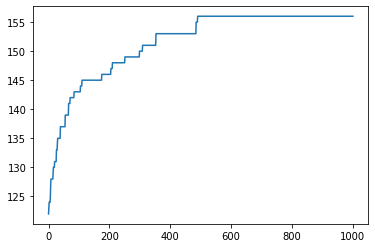

Poblacion inicial, best_fitness = 125
Best board found in 5.294134855270386 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  329


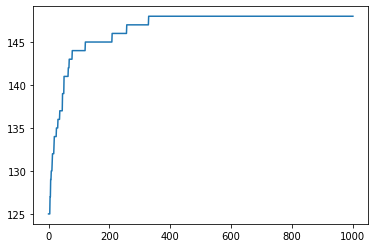

Poblacion inicial, best_fitness = 126
Best board found in 5.0421388149261475 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  193


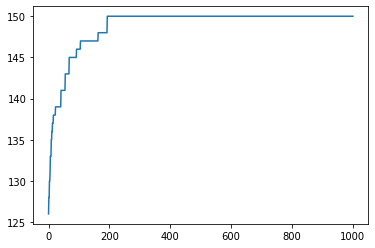

Poblacion inicial, best_fitness = 120
Best board found in 5.0981504917144775 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  348


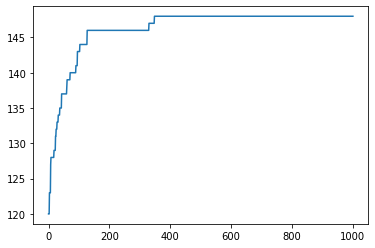

Poblacion inicial, best_fitness = 123
Best board found in 5.07647967338562 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  331


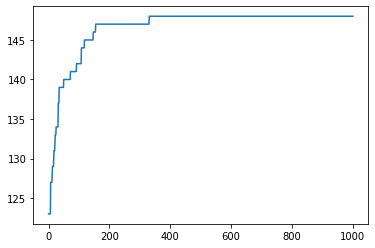

Poblacion inicial, best_fitness = 124
Best board found in 5.235416889190674 seconds (1000 ierations) with 154/162 points:
Last Gen with improvement:  238


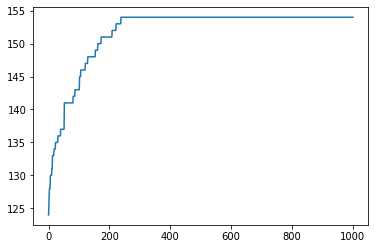

Poblacion inicial, best_fitness = 127
Best board found in 5.185304164886475 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  143


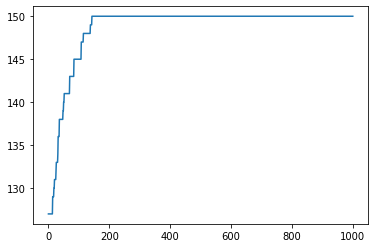

Poblacion inicial, best_fitness = 122
Best board found in 5.040138244628906 seconds (1000 ierations) with 143/162 points:
Last Gen with improvement:  93


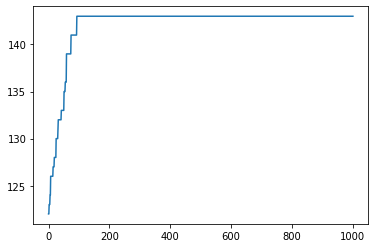

In [29]:
#generacion_fitness_mean_list=[]
#generacion_fitness_max_list=[]
#bestfitness_02a_max_mean_list=[]


pmut_index = pmut[2]
metodoSeleccionpadres_index = metodoSeleccionpadres[2]

gen_max_fitness_mean_list = []
max_fitness_mean_list = []


for crossover_index in crossover:

    print("/"*60)
    print("Taza de Mutacion: ", pmut_index)
    print("Operador de Cruze: ", crossover_index)
    print('Modo de seleccion de padres: ', metodoSeleccionpadres_index)
    print('\n')

    gen_max_fitness_list = []
    max_fitness_list = []

    for i in range(0,10):
        population = init_population(num_individuals, board, initialEntries)
        best_ind, bestfitness, gen_max_fitness, max_fitness = genetic_algorithm(population, fitness_fn, ngen = ngen,
                                                  pmut = pmut_index,
                                                  pcx = pcx,
                                                  tournament_size = tournament_size, 
                                                  crossover = crossover_index,
                                                  mutation = mutation[0],
                                                  selection_parents_method = metodoSeleccionpadres_index,
                                                  selection_survivors_method = metodoSeleccionsobrevivientes[0])
        plt.plot(bestfitness)
        plt.show()

        gen_max_fitness_list.append(gen_max_fitness)
        max_fitness_list.append(max_fitness)



    gen_max_fitness_array=np.asarray(gen_max_fitness_list)
    max_fitness_array=np.asarray(max_fitness_list)
    gen_max_fitness_mean=np.mean(gen_max_fitness_array)
    max_fitness_mean=np.mean(max_fitness_array)

    gen_max_fitness_mean_list.append(gen_max_fitness_mean)
    max_fitness_mean_list.append(max_fitness_mean)



                

<function matplotlib.pyplot.show(close=None, block=None)>

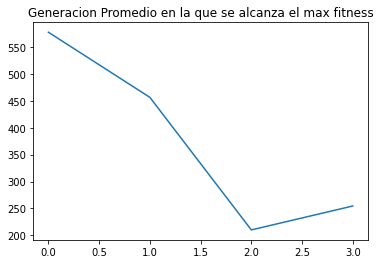

In [30]:
plt.plot(gen_max_fitness_mean_list)
plt.title('Generacion Promedio en la que se alcanza el max fitness')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

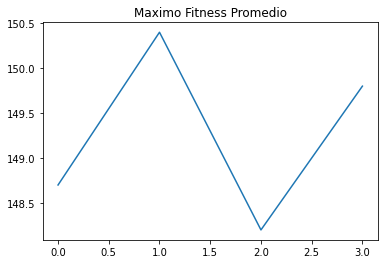

In [31]:
plt.plot(max_fitness_mean_list)
plt.title('Maximo Fitness Promedio')
plt.show

////////////////////////////////////////////////////////////
Taza de Mutacion:  0.5
Operador de Cruze:  onepoint
Modo de seleccion de padres:  tournament


Poblacion inicial, best_fitness = 125
Best board found in 1.5143420696258545 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  219


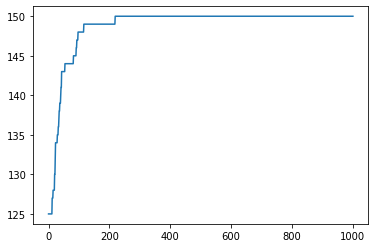

Poblacion inicial, best_fitness = 122
Best board found in 1.4903366565704346 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  130


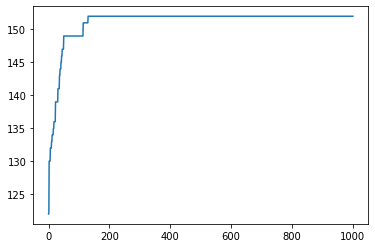

Poblacion inicial, best_fitness = 122
Best board found in 1.494337797164917 seconds (1000 ierations) with 154/162 points:
Last Gen with improvement:  461


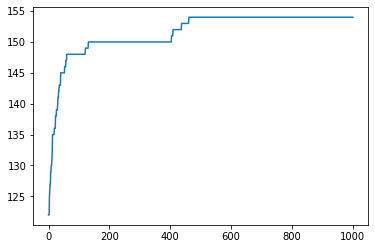

Poblacion inicial, best_fitness = 120
Best board found in 1.4703319072723389 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  626


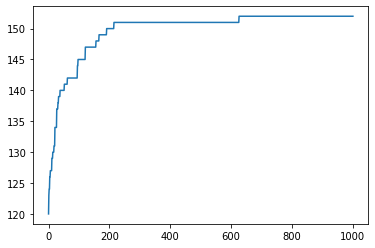

Poblacion inicial, best_fitness = 123
Best board found in 1.5033400058746338 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  170


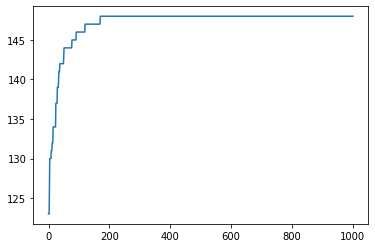

Poblacion inicial, best_fitness = 121
Best board found in 1.4863355159759521 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  419


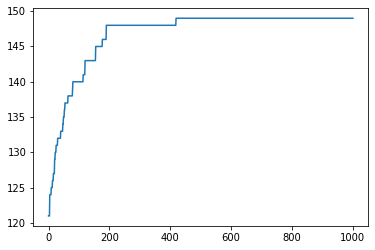

Poblacion inicial, best_fitness = 125
Best board found in 1.495337724685669 seconds (1000 ierations) with 151/162 points:
Last Gen with improvement:  276


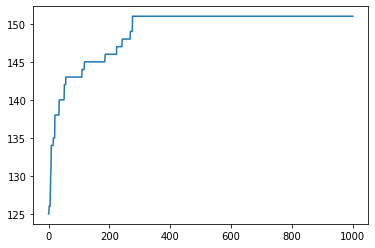

Poblacion inicial, best_fitness = 124
Best board found in 1.4983375072479248 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  450


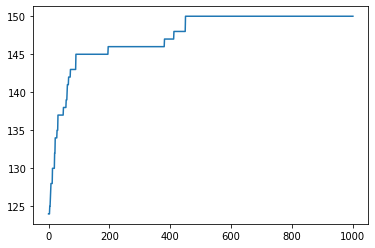

Poblacion inicial, best_fitness = 136
Best board found in 1.4867150783538818 seconds (1000 ierations) with 147/162 points:
Last Gen with improvement:  202


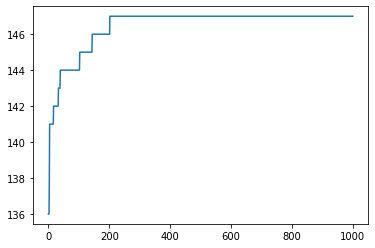

Poblacion inicial, best_fitness = 126
Best board found in 1.4939959049224854 seconds (1000 ierations) with 153/162 points:
Last Gen with improvement:  281


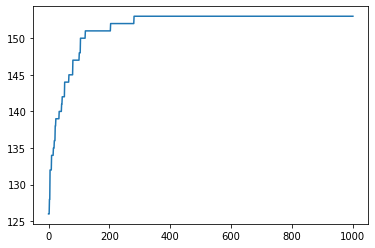

////////////////////////////////////////////////////////////
Taza de Mutacion:  0.5
Operador de Cruze:  multipoint
Modo de seleccion de padres:  tournament


Poblacion inicial, best_fitness = 124
Best board found in 1.4402077198028564 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  190


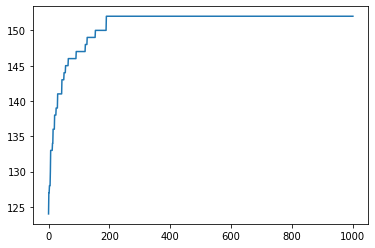

Poblacion inicial, best_fitness = 122
Best board found in 1.4153025150299072 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  89


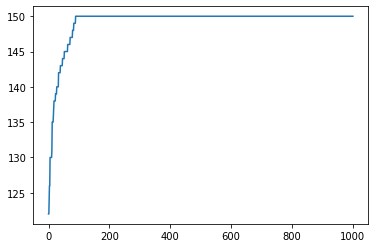

Poblacion inicial, best_fitness = 125
Best board found in 1.424006700515747 seconds (1000 ierations) with 153/162 points:
Last Gen with improvement:  85


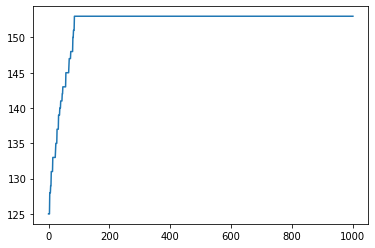

Poblacion inicial, best_fitness = 119
Best board found in 1.4439926147460938 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  188


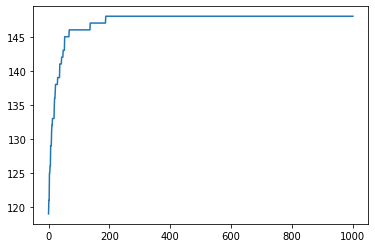

Poblacion inicial, best_fitness = 126
Best board found in 1.4280989170074463 seconds (1000 ierations) with 151/162 points:
Last Gen with improvement:  238


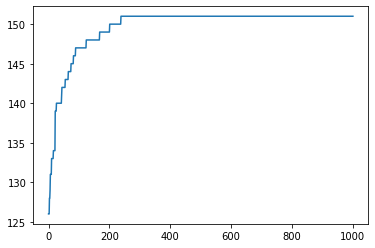

Poblacion inicial, best_fitness = 125
Best board found in 1.4223191738128662 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  201


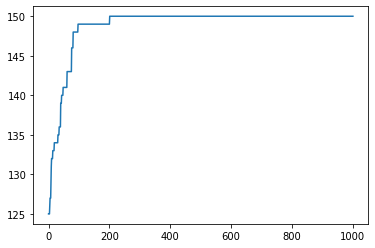

Poblacion inicial, best_fitness = 126
Best board found in 1.4183197021484375 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  100


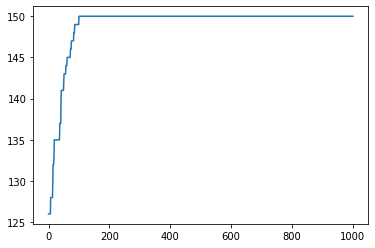

Poblacion inicial, best_fitness = 124
Best board found in 1.4253261089324951 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  378


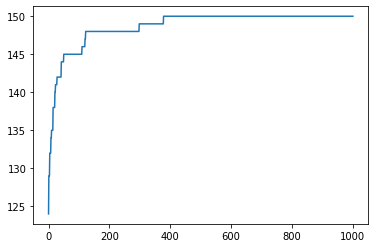

Poblacion inicial, best_fitness = 123
Best board found in 1.4443261623382568 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  429


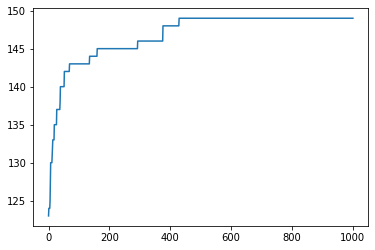

Poblacion inicial, best_fitness = 122
Best board found in 1.4503278732299805 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  163


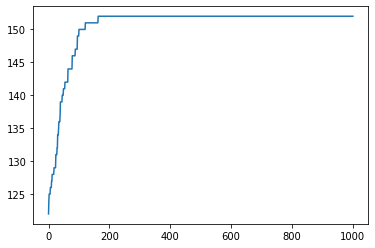

////////////////////////////////////////////////////////////
Taza de Mutacion:  0.5
Operador de Cruze:  orderpermutation
Modo de seleccion de padres:  tournament


Poblacion inicial, best_fitness = 122
Best board found in 1.365307092666626 seconds (1000 ierations) with 153/162 points:
Last Gen with improvement:  539


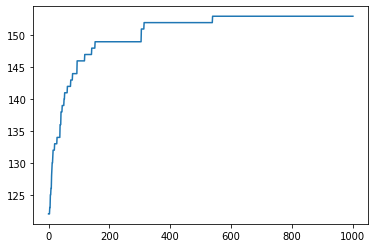

Poblacion inicial, best_fitness = 118
Best board found in 1.3753106594085693 seconds (1000 ierations) with 147/162 points:
Last Gen with improvement:  117


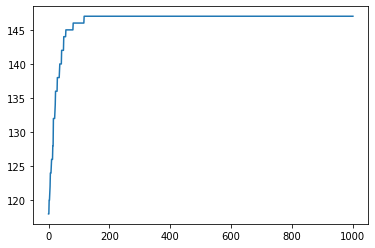

Poblacion inicial, best_fitness = 122
Best board found in 1.3643074035644531 seconds (1000 ierations) with 144/162 points:
Last Gen with improvement:  58


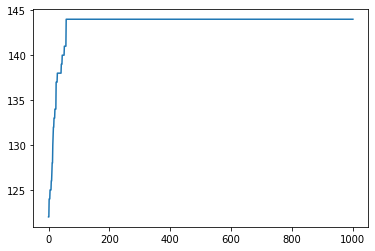

Poblacion inicial, best_fitness = 127
Best board found in 1.3683085441589355 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  93


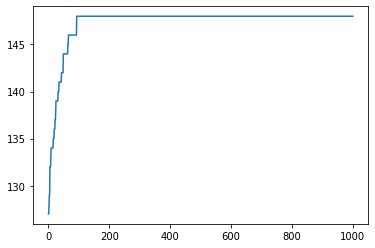

Poblacion inicial, best_fitness = 117
Best board found in 1.3663086891174316 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  453


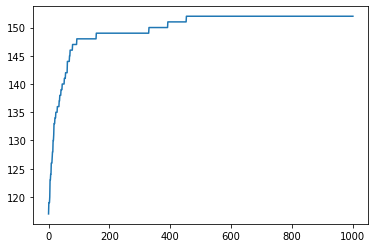

Poblacion inicial, best_fitness = 124
Best board found in 1.3683090209960938 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  103


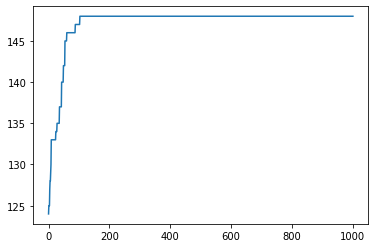

Poblacion inicial, best_fitness = 125
Best board found in 1.3563051223754883 seconds (1000 ierations) with 145/162 points:
Last Gen with improvement:  731


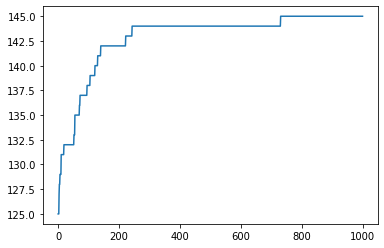

Poblacion inicial, best_fitness = 124
Best board found in 1.3653085231781006 seconds (1000 ierations) with 153/162 points:
Last Gen with improvement:  328


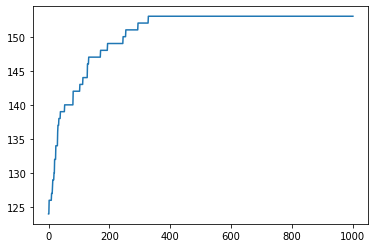

Poblacion inicial, best_fitness = 122
Best board found in 1.370309591293335 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  294


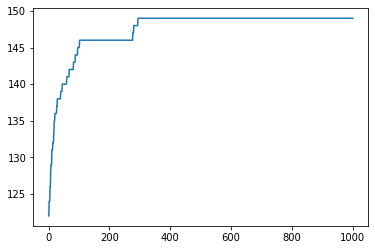

Poblacion inicial, best_fitness = 125
Best board found in 1.3783106803894043 seconds (1000 ierations) with 156/162 points:
Last Gen with improvement:  469


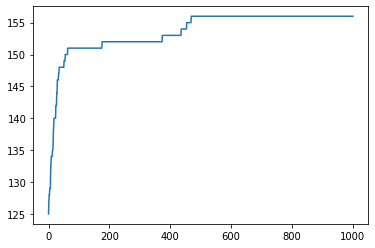

////////////////////////////////////////////////////////////
Taza de Mutacion:  0.5
Operador de Cruze:  PMXpermutation
Modo de seleccion de padres:  tournament


Poblacion inicial, best_fitness = 122
Best board found in 5.322800636291504 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  64


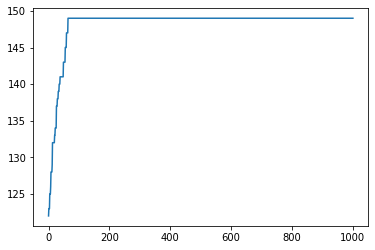

Poblacion inicial, best_fitness = 122
Best board found in 5.355519533157349 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  103


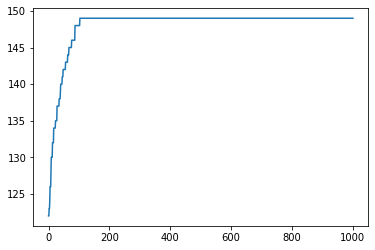

Poblacion inicial, best_fitness = 124
Best board found in 5.313198566436768 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  93


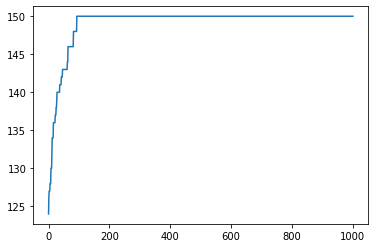

Poblacion inicial, best_fitness = 124
Best board found in 5.330203533172607 seconds (1000 ierations) with 149/162 points:
Last Gen with improvement:  202


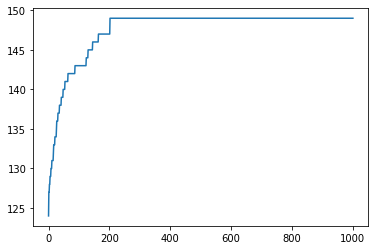

Poblacion inicial, best_fitness = 127
Best board found in 5.318200588226318 seconds (1000 ierations) with 143/162 points:
Last Gen with improvement:  63


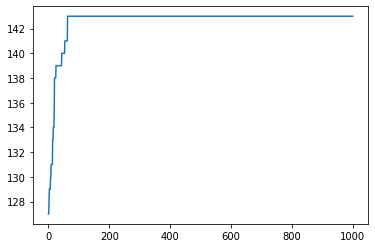

Poblacion inicial, best_fitness = 123
Best board found in 5.3162009716033936 seconds (1000 ierations) with 156/162 points:
Last Gen with improvement:  223


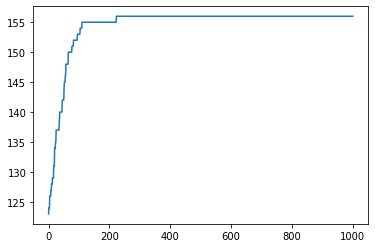

Poblacion inicial, best_fitness = 126
Best board found in 5.350239515304565 seconds (1000 ierations) with 152/162 points:
Last Gen with improvement:  140


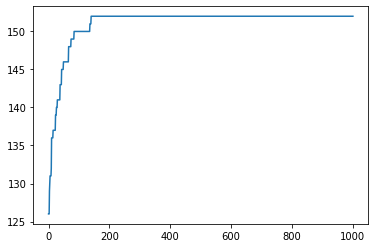

Poblacion inicial, best_fitness = 121
Best board found in 5.32106351852417 seconds (1000 ierations) with 148/162 points:
Last Gen with improvement:  114


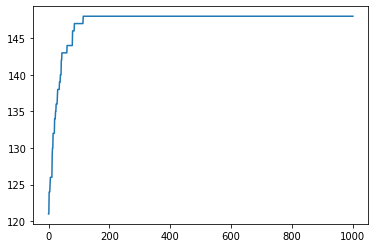

Poblacion inicial, best_fitness = 125


In [ ]:
#generacion_fitness_mean_list=[]
#generacion_fitness_max_list=[]
#bestfitness_02a_max_mean_list=[]


pmut_index = pmut[3]
metodoSeleccionpadres_index = metodoSeleccionpadres[1]

gen_max_fitness_mean_list = []
max_fitness_mean_list = []


for crossover_index in crossover:

    print("/"*60)
    print("Taza de Mutacion: ", pmut_index)
    print("Operador de Cruze: ", crossover_index)
    print('Modo de seleccion de padres: ', metodoSeleccionpadres_index)
    print('\n')

    gen_max_fitness_list = []
    max_fitness_list = []

    for i in range(0,10):
        population = init_population(num_individuals, board, initialEntries)
        best_ind, bestfitness, gen_max_fitness, max_fitness = genetic_algorithm(population, fitness_fn, ngen = ngen,
                                                  pmut = pmut_index,
                                                  pcx = pcx,
                                                  tournament_size = tournament_size, 
                                                  crossover = crossover_index,
                                                  mutation = mutation[0],
                                                  selection_parents_method = metodoSeleccionpadres_index,
                                                  selection_survivors_method = metodoSeleccionsobrevivientes[0])
        plt.plot(bestfitness)
        plt.show()

        gen_max_fitness_list.append(gen_max_fitness)
        max_fitness_list.append(max_fitness)



    gen_max_fitness_array=np.asarray(gen_max_fitness_list)
    max_fitness_array=np.asarray(max_fitness_list)
    gen_max_fitness_mean=np.mean(gen_max_fitness_array)
    max_fitness_mean=np.mean(max_fitness_array)

    gen_max_fitness_mean_list.append(gen_max_fitness_mean)
    max_fitness_mean_list.append(max_fitness_mean)



                

In [ ]:
plt.plot(gen_max_fitness_mean_list)
plt.title('Generacion Promedio en la que se alcanza el max fitness')
plt.show

In [ ]:
plt.plot(max_fitness_mean_list)
plt.title('Maximo Fitness Promedio')
plt.show